# 7章

注: この章では地理データを扱うため, 地理情報システム (GIS) に関連した分野特有のパッケージが要求されます. ここでは **geopandas**, **libpysal**, **cartopy** パッケージを特に使用します. 場合によっては, 最後のパッケージはいくつかの C++ ライブラリが必要になるかもしれません. 例えば Ubuntu os を使用しているなら, 以下のようにしてインストールできます:

```sh
apt install libgeos-dev libgeos++-dev
```

詳細は[公式ドキュメント](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing)を見てください.

注: **Plotnine** にも `geom_polygon()` 関数がありますが 現時点 (v0.8) では `geom_map()` もサポートしており, これは **ggplot2**  (>3.0.0) でいう `geom_map()` や `geom_polygon()` ではなく `geom_sf()` に対応しています. `geom_map()` は緯度経度をx/yに指定したり, `group` を指定したりする必要がなく, `geopandas.DataFrame` オブジェクトに適切な `geometry` 列が含まれていさえすればよいため便利です. よって以下の例では, `geom_polygon` のかわりに `geom_map` を使っている箇所があります. 

In [1]:
# minimal imports
import pandas as pd
import geopandas as gp
import numpy as np
from plotnine import *
import plotnine.options as p9options

# for graphical enhancement
from mizani.labels import label_date, label_dollar, label_percent, label_comma
from mizani.palettes import brewer_pal
from pysocviz.p9extra import theme_map_pseudo

# In most cases, you may not import them.
# you may need them If only you are adhere to color tweaking...
from pysocviz.properties import dcolors

# This function is used for only 図 7.14 and 7.15.
from pysocviz.utils import statebins

p9options.figure_size = (6.4, 5.8)
theme_set(theme_minimal(base_family='Noto Sans CJK JP'))

# For figure 7.5
from cartopy import crs as ccrs 

In [2]:
from pysocviz.loader import load_dataset

election = load_dataset('election')

import libpysal  # >= 4.5.1

election = load_dataset('election')
county_map = load_dataset('county_map')
county_data = load_dataset('county_data')
opiates = load_dataset('opiates')

## 図 7.2

注 1: 原著オンライン版では "Democrat" と表示されていますがデータセット内の正確なラベルは "Democratic" です.

注 2: カラーマッピングについての意見はもうこれ以上繰り返したくありません.

In [3]:
party_colors = ["#2E74C0", "#CB454A"] # Democratic - Republican
party_colors = dict(zip(np.sort(election['party'].unique()), party_colors))

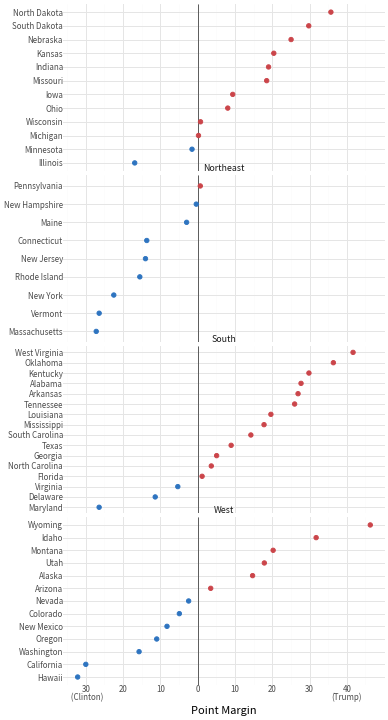

In [4]:
p0 = ggplot(
    election.loc[lambda d: ~d['st'].isin(['DC'])],
    aes(x='r_points', y='reorder(state, r_points)', color='party')
)
p1 = p0 + geom_vline(xintercept=0, color=dcolors['gray30']
) + geom_point(size=2)
p2 = p1 + scale_color_manual(values=party_colors)
p3 = p2 + scale_x_continuous(
    breaks = [-30, -20, -10, 0, 10, 20, 30, 40],
    labels = ["30\n (Clinton)", "20", "10", "0",
               "10", "20", "30", "40\n(Trump)"]
)

p3 + facet_wrap('~ census', ncol=1, scales='free_y') + guides(
    color=False) + labs(x="Point Margin", y="") + theme(
    axis_text=element_text(size=8), figure_size=(5.4, 10))

## 図 7.3

注 1: この例では, **libpysal** パッケージから地理データを読み込んでいます. 本資料を通して, **libpysal** はデータセットのインポートのみに使用しています. 

In [5]:
# dataset information
libpysal.examples.explain('us_income')

us_income

Per-capita income for the lower 48 US states 1929-2009
------------------------------------------------------

* spi_download.csv: regional per capita income time series 1969-2008. (source:  Regional Economic Information System, Bureau of Economic Analysis, U.S. Department of Commerce) 
* states48.gal: contiguity weights in GAL format.
* us48.dbf: attribute data. (k=8)
* us48.shp: Polygon shapefile. (n=48) 
* us48.shx: spatial index.
* usjoin.csv: 48 US states per capita income time series 1929-2009.



In [6]:
# read SHP file from libpysal
us_states = gp.read_file(libpysal.examples.get_path('us48.shp'))
us_states = us_states.set_crs('EPSG:4326')

# to adjust to imitate the R dataset
us_states = us_states.rename(columns={c: c.lower() for c in us_states.columns})
us_states = us_states.rename(
    columns={'state_name': 'region', 'sub_region': 'subregion'})
us_states = us_states.drop(
    columns=['area', 'state_', 'perimeter', 'state_id', 'state_fips'])
us_states = us_states.assign(region=lambda d: d['region'].str.lower())
us_states.head()

region subregion state_abbr  \
0    washington   Pacific         WA   
1       montana       Mtn         MT   
2         maine     N Eng         ME   
3  north dakota   W N Cen         ND   
4  south dakota   W N Cen         SD   

                                            geometry  
0  MULTIPOLYGON (((-122.40075 48.22540, -122.4615...  
1  POLYGON ((-111.47463 44.70224, -111.48001 44.6...  
2  MULTIPOLYGON (((-69.77779 44.07407, -69.86044 ...  
3  POLYGON ((-98.73006 45.93830, -99.00645 45.939...  
4  POLYGON ((-102.78793 42.99532, -103.00541 42.9...

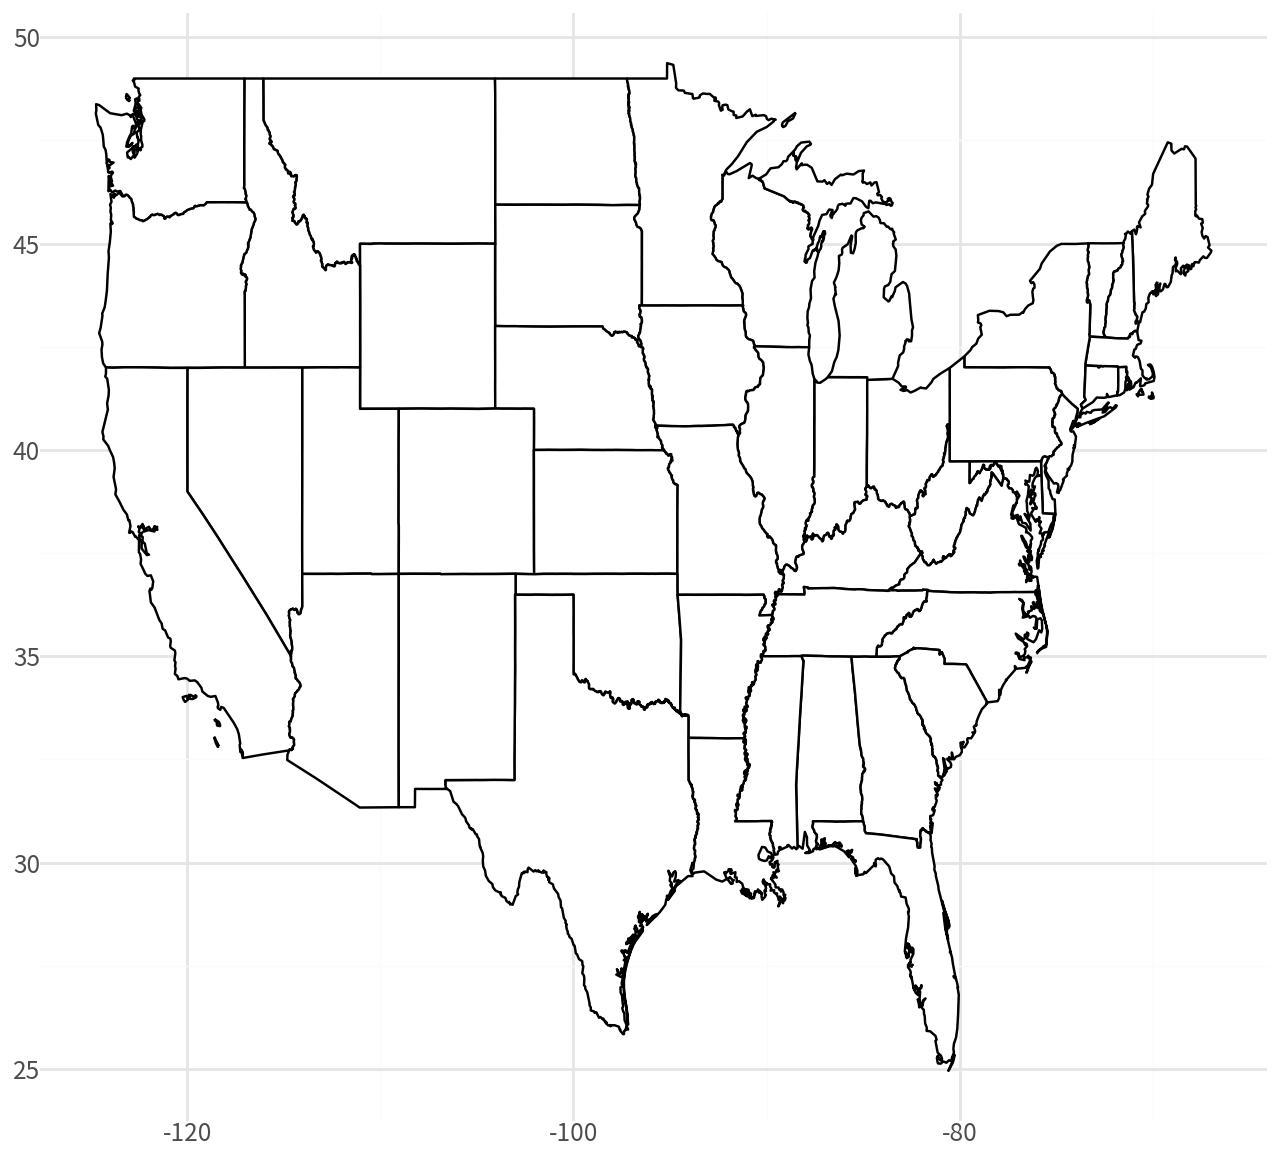

In [7]:
ggplot(us_states) + geom_map(fill='white', color='black')

## 図 7.4

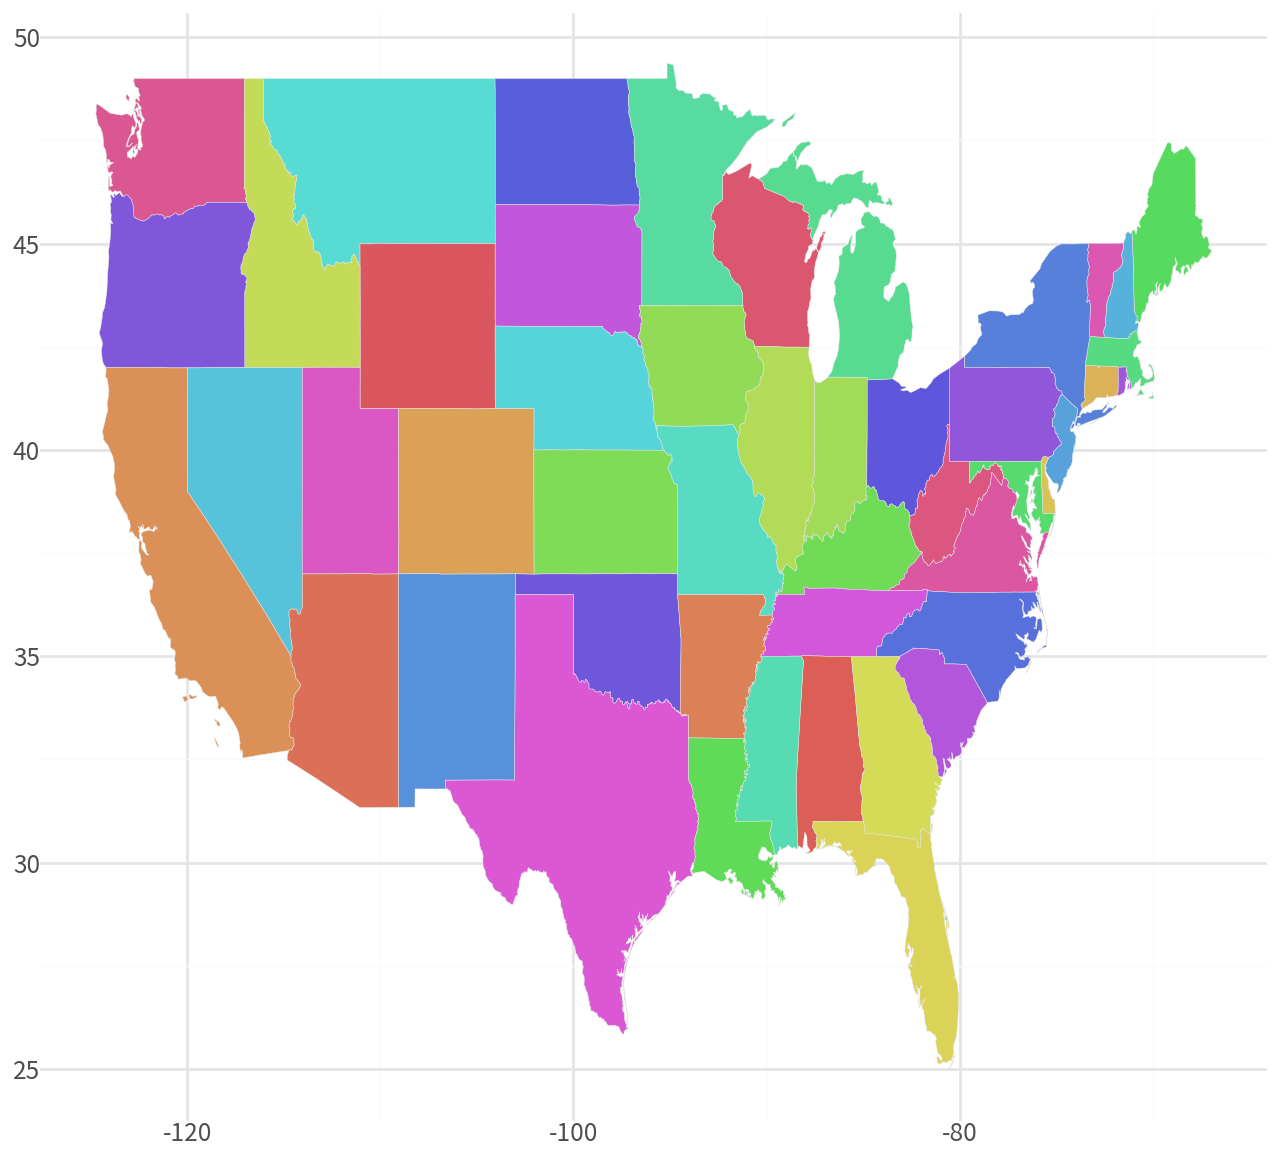

In [8]:
p = ggplot(
    us_states,
    aes(fill='region')
)
p + geom_map(
    color=dcolors['gray90'], size=0.1
) + guides(fill=False)

## 図 7.5

注: **Plotnine** は現時点 (v0.8) では Albers その他の投影図法の変換をサポートしていません (ただし将来的にはするかもしれません:  https://github.com/has2k1/plotnine/issues/14). 投影法の変換には **geopandas** と **cartopy** パッケージを使います.

https://geopandas.org/gallery/cartopy_convert.html

変換後はデータセットに含まれる座標が直交座標系でなくなることに注意してください. つまり,  x/y  軸は実際の座標に対応していません.

最初に, デフォルトCRSを設定して変換する方法を紹介します.

In [9]:
us_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

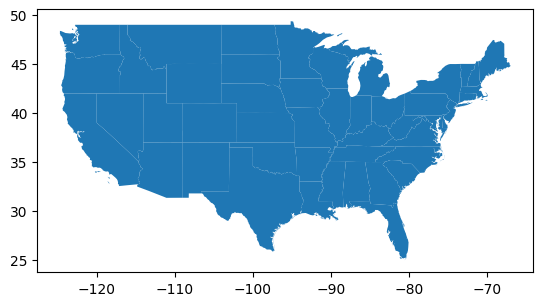

In [10]:
us_states.plot()

それから Albers 投影法に変換します

/tmp/ipykernel_19039/2785240289.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_19039/2785240289.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



<Axes: >

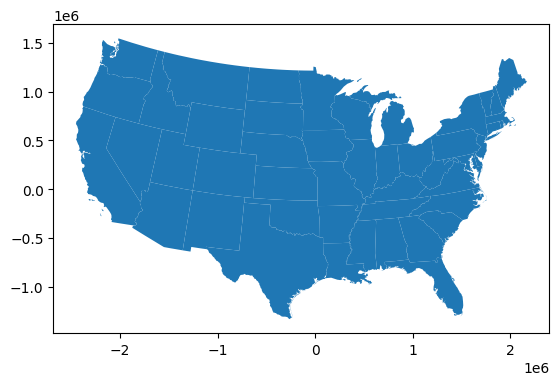

In [11]:
from cartopy import crs as ccrs
crs_Albers = ccrs.AlbersEqualArea(
    central_longitude=(us_states.centroid.to_crs('EPSG:4326').x.min() + us_states.centroid.to_crs('EPSG:4326').x.max())/2,
    central_latitude=(us_states.centroid.to_crs('EPSG:4326').y.min() + us_states.centroid.to_crs('EPSG:4326').y.max())/2,
    standard_parallels=(39, 45))
crs_proj4 = crs_Albers.proj4_init
us_states = us_states.to_crs(crs_proj4)
us_states.plot()

注: この方法ではグリッド線までは Albers 投影図法に変換できないことに注意してください.

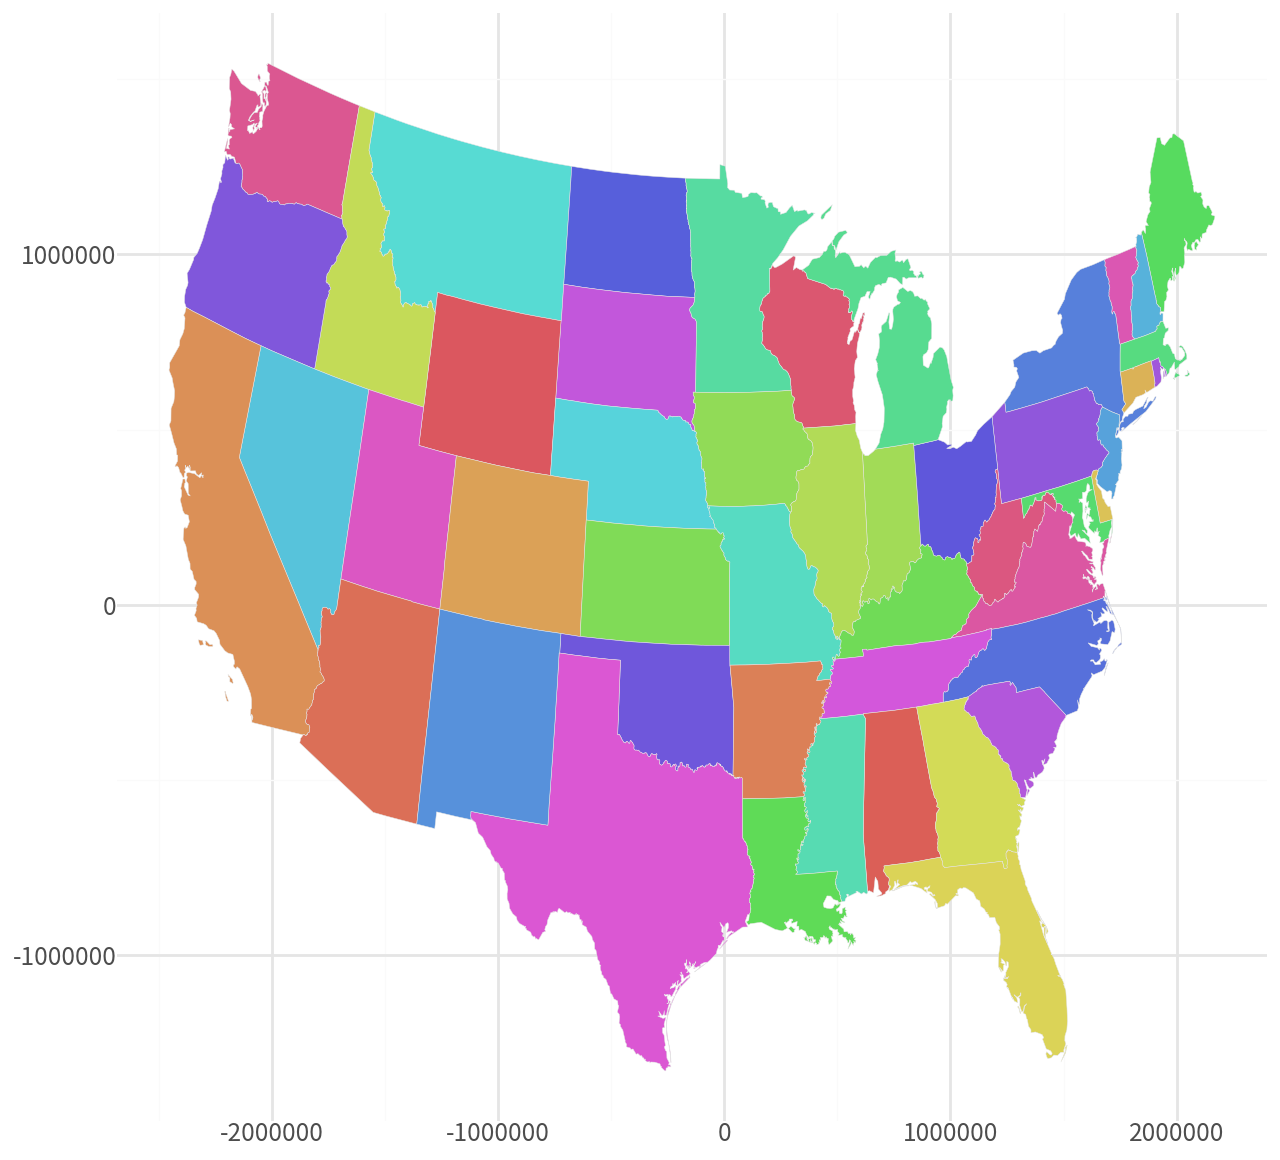

In [12]:
# If you input this dataset, the shape is same but lon/lat labels are incorrect.
p = ggplot(
    us_states,
    aes(fill='region')
)
p + geom_map(
    color=dcolors['gray90'], size=0.1
) + guides(fill=False)

## 図 7.6

In [13]:
election = election.assign(region=lambda d: d['state'].str.lower())
us_states_elec = us_states.merge(election, on='region', how='left')

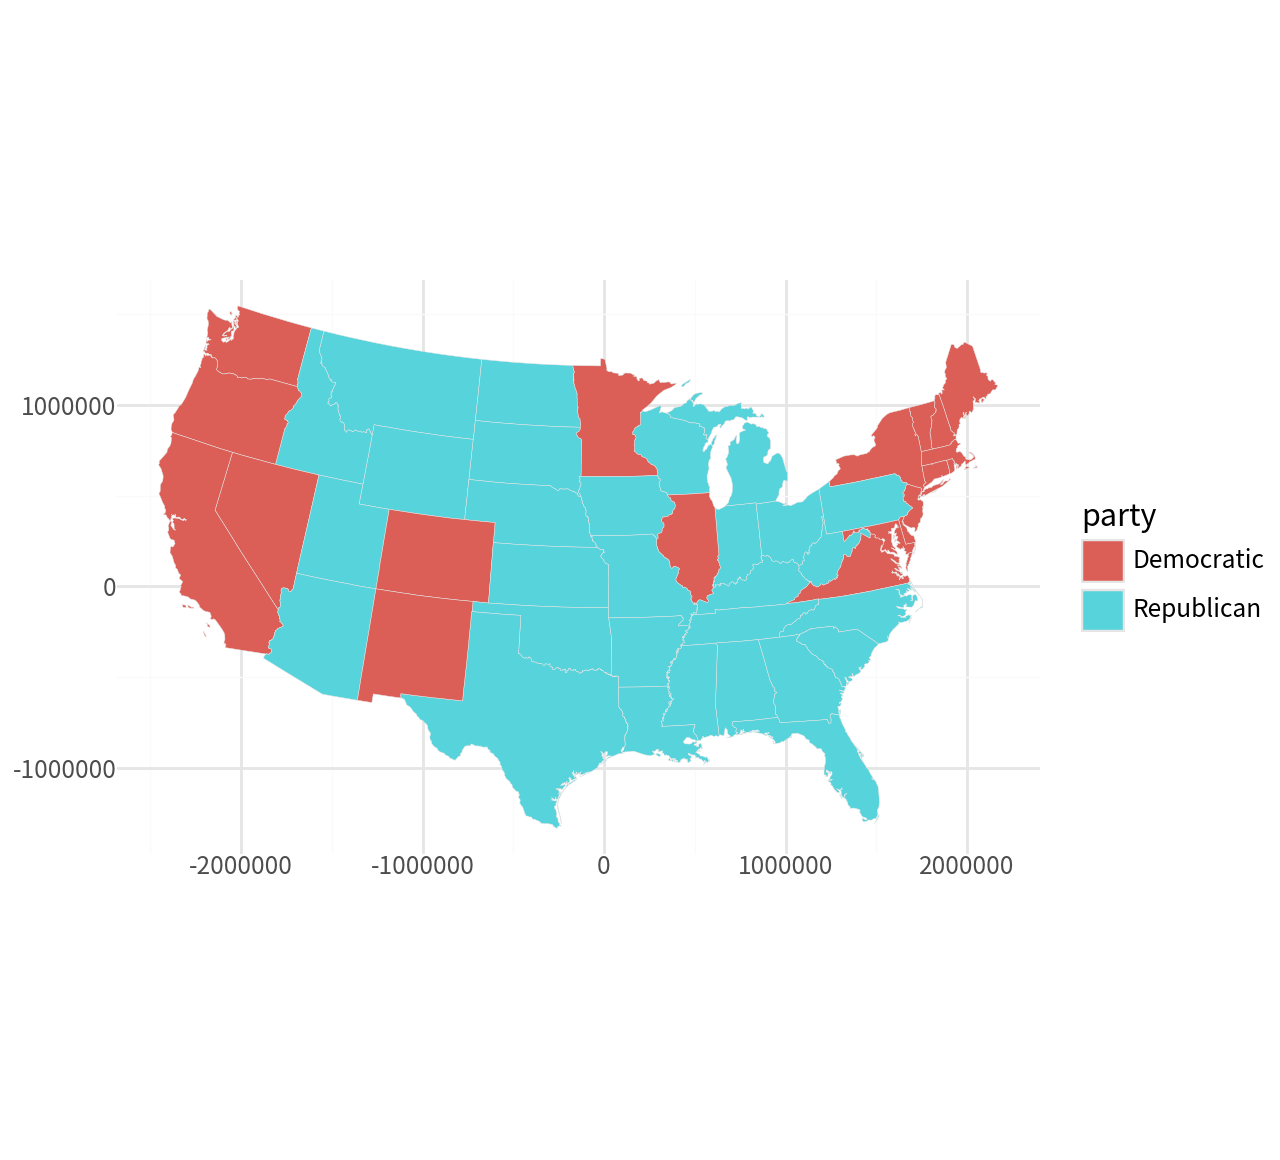

In [14]:
p = ggplot(us_states_elec, aes(fill='party'))
p + geom_map(color=dcolors['gray90'], size=0.1) + coord_fixed()

## 図 7.7

注: **plotnine** は現時点 (v0.8) では `theme_map` をサポートしていません. そのためここでは似たようなデザインのテーマを自分で設定しています. このテーマは `from pysocviz.p9extra import theme_map_pseudo` でインポートできます.

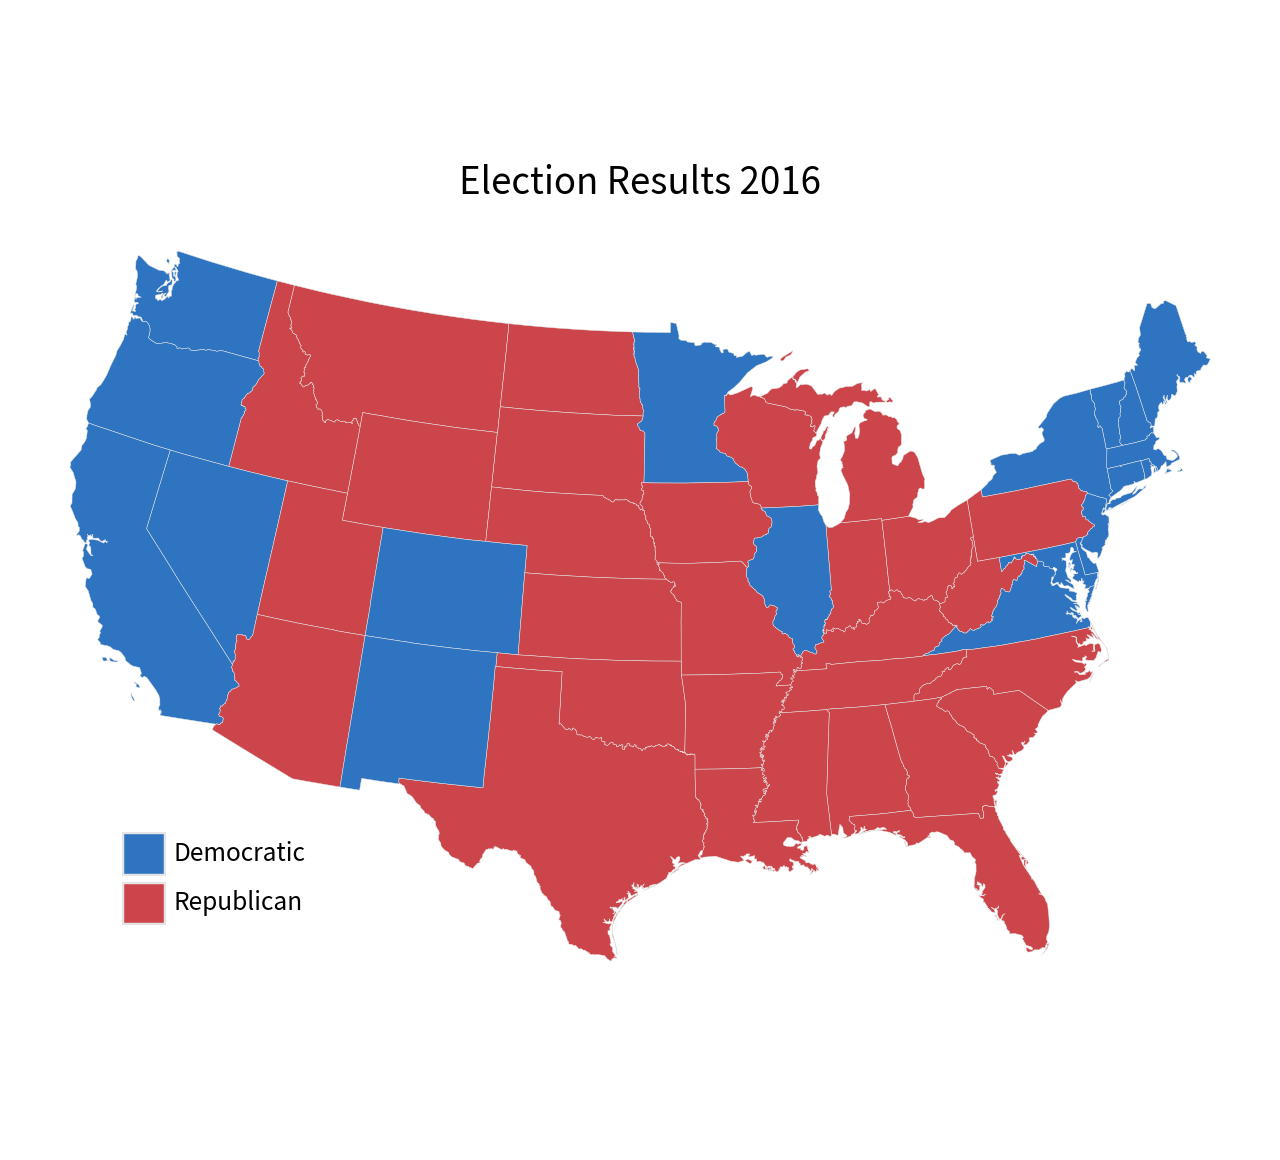

In [15]:
p0 = ggplot(us_states_elec, aes(fill='party'))
p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1) 
p2 = p1 + scale_fill_manual(values=party_colors) + labs(
    title="Election Results 2016")

p2 + theme_map_pseudo() + coord_fixed()

## 図 7.8

In [16]:
p0 = ggplot(us_states_elec, aes(fill='pct_trump'))

p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1)

(
    p1 + labs(title="Trump vote") + theme_map_pseudo(
    ) + labs(fill="Percent") + scale_fill_cmap('Blues')  + coord_fixed()
).draw();

p2 = p1 + scale_fill_gradient(
    low="white", high="#CB454A") + labs(title = "Trump vote")
(
    p2 + theme_map_pseudo() + labs(fill = "Percent") + coord_fixed()
).draw();

## 図 7.9

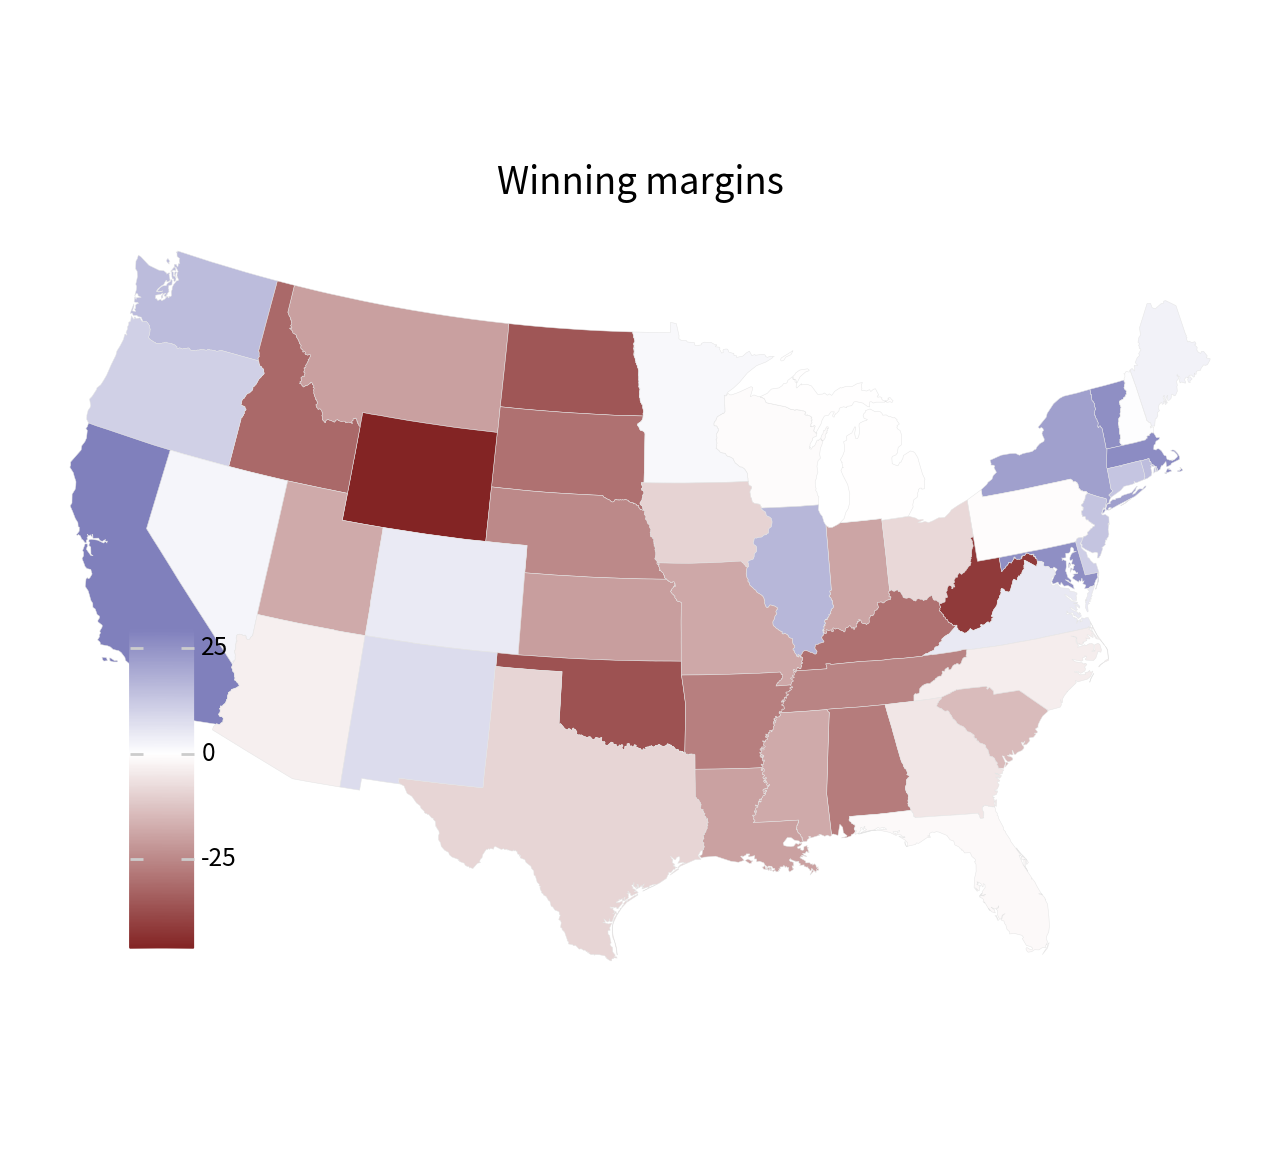

In [17]:
p0 = ggplot(us_states_elec, aes(fill='d_points'))

p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1) + coord_fixed() 

p2 = p1 + scale_fill_gradient2() + labs(title = "Winning margins") 
p2 + theme_map_pseudo() + labs(fill = "Percent")

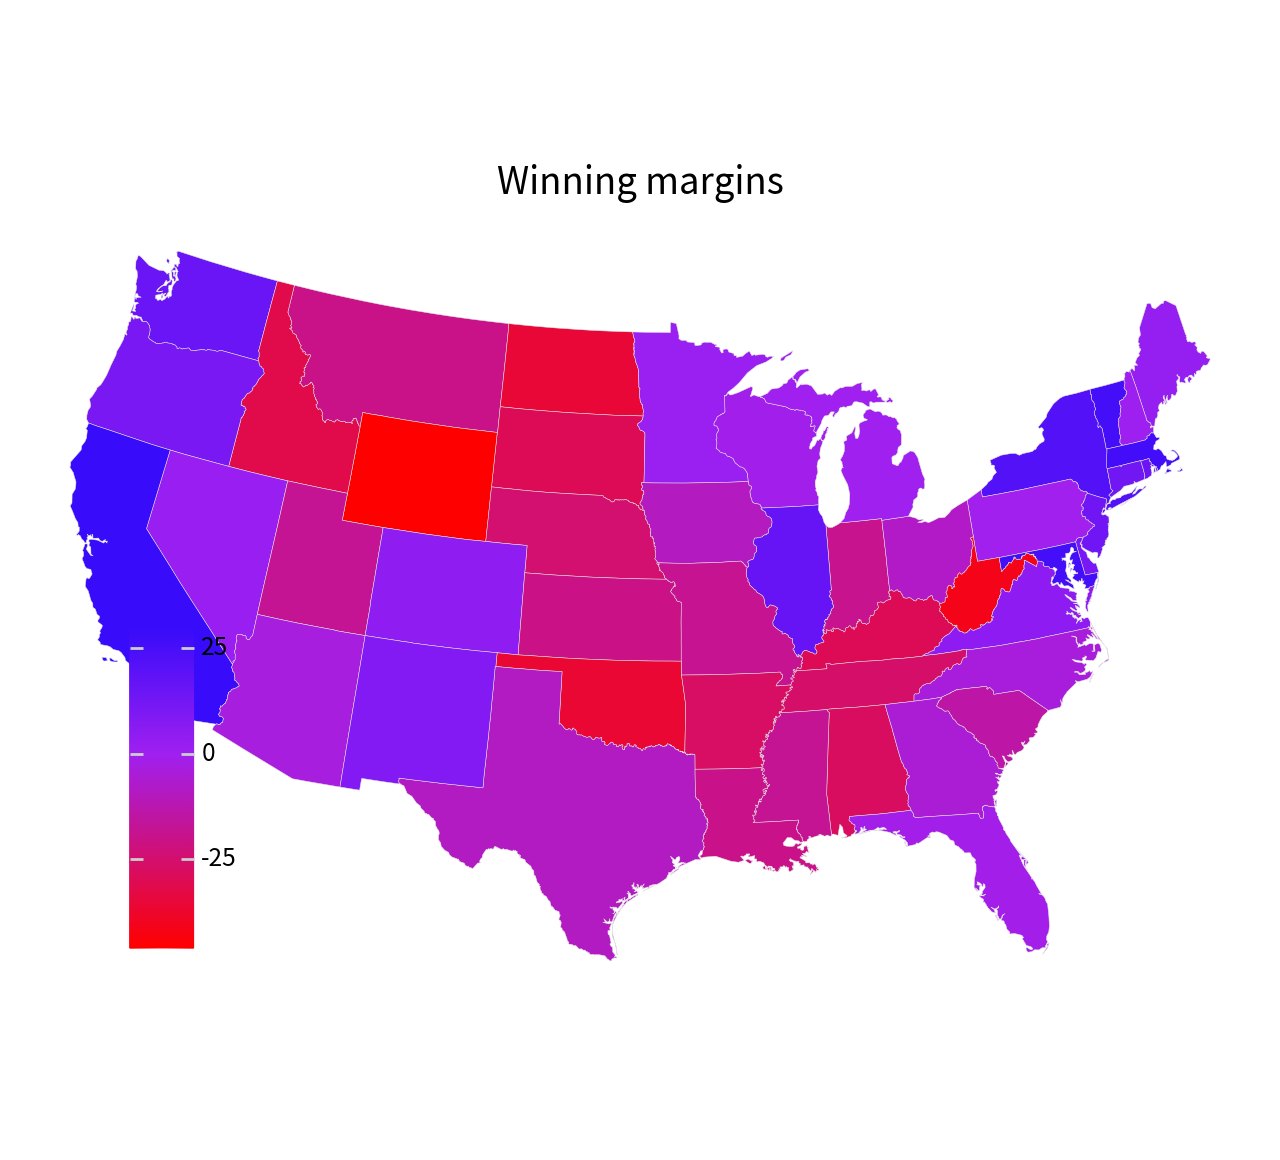

In [18]:
p3 = p1 + scale_fill_gradient2(
    low="red", mid=dcolors['purple'], high="blue",
    breaks = [-25, 0, 25, 50, 75]
) + labs(title="Winning margins") 
p3 + theme_map_pseudo() + labs(fill = "Percent")

## 図 7.10

注: R のデータセットとは異なり, **libpysal** からインポートしたデータセットはワシントン D.C. (District of Columbia) を含んでいません.

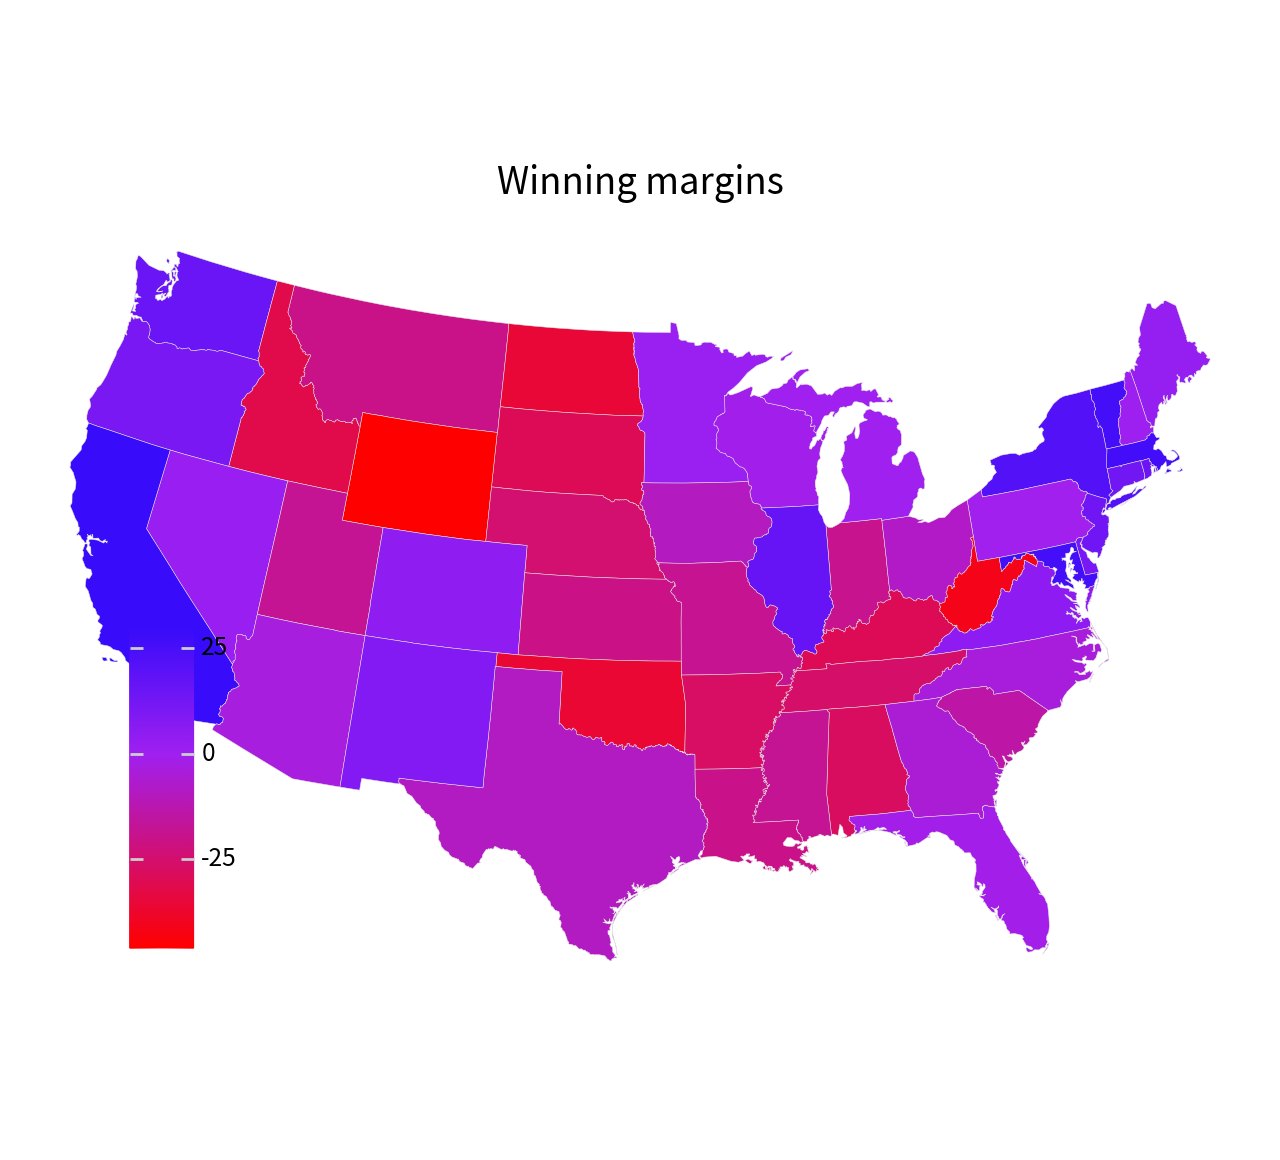

In [19]:
p0 = ggplot(
    us_states_elec.loc[lambda d: ~d['region'].isin(['district of columbia'])],
    aes(fill='d_points')
)

p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1) + coord_fixed()

p2 = p1 + scale_fill_gradient2(
    low = "red", mid=dcolors['purple'], high = "blue"
) + labs(title="Winning margins") 
p2 + theme_map_pseudo() + labs(fill="Percent")

## 図 7.11 

注 1: `county_map` の各行には, 多角形の頂点座標が含まれています. よってここからは `geom_polygon` を使用します.

注 2: `country_map` の `long`/`lat` 各列は実際の緯度経度ではありません.

In [20]:
county_full = county_map.merge(county_data, on='id', how='left')

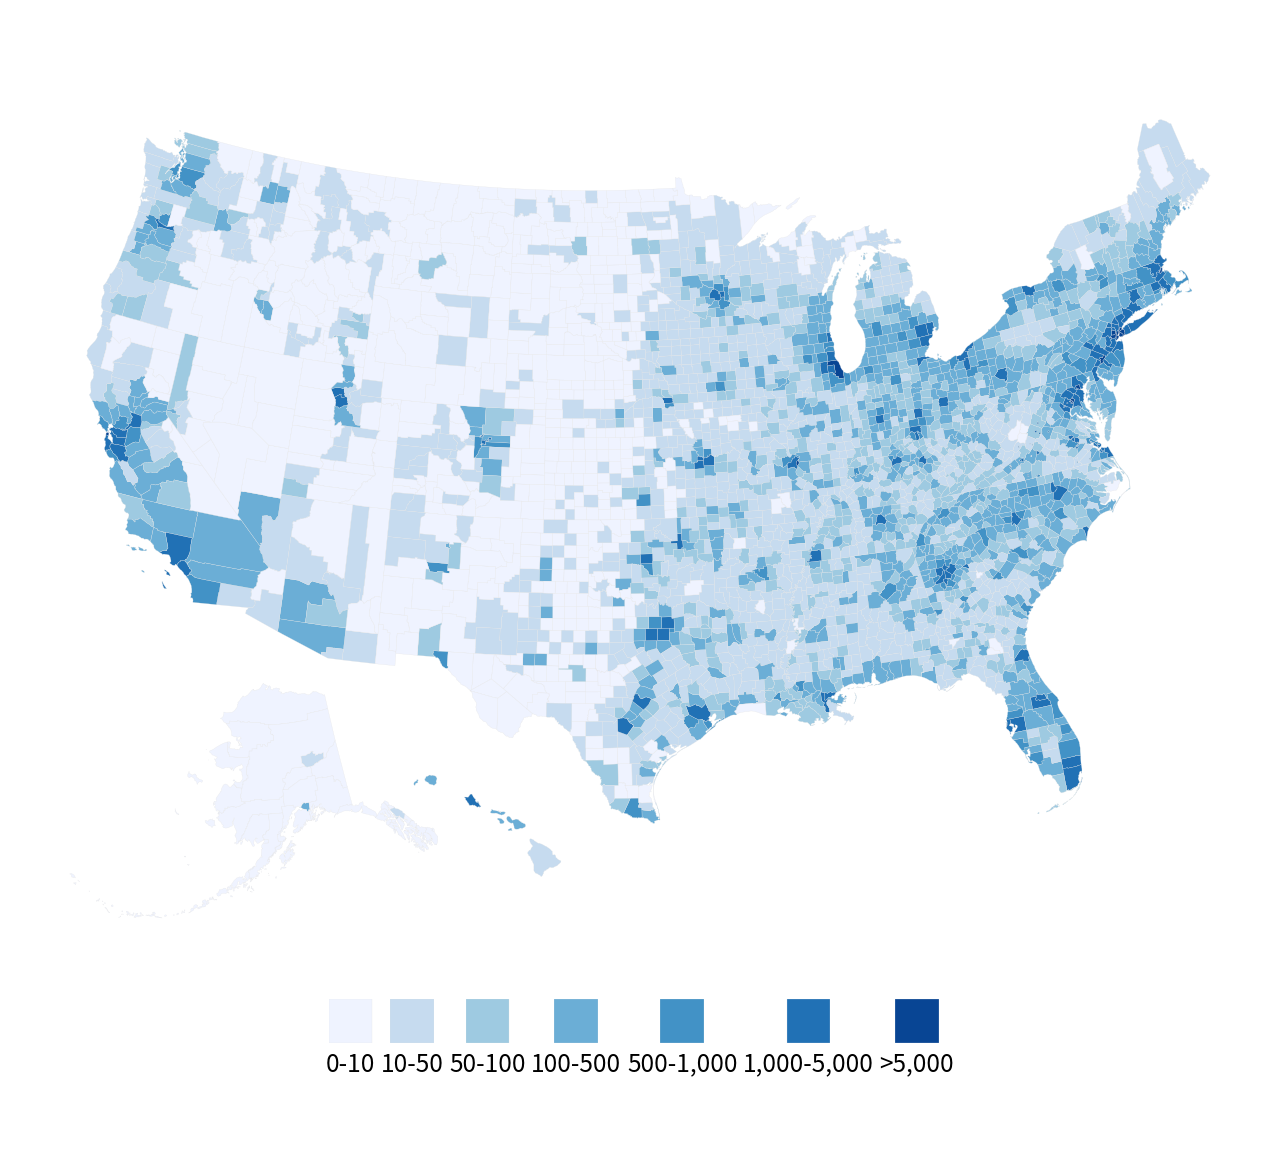

In [21]:
p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='pop_dens',  group='group')
)

p1 = p + geom_polygon(color=dcolors['gray90'], size=0.05) + coord_equal()

p2 = p1 + scale_fill_brewer(
    palette="Blues",
    labels=["0-10", "10-50", "50-100", "100-500", "500-1,000", "1,000-5,000", ">5,000"]
)

p2 + labs(fill="Population per\nsquare mile") + theme_map_pseudo(
) + guides(fill=guide_legend(nrow=1)) +  theme(legend_position="bottom")

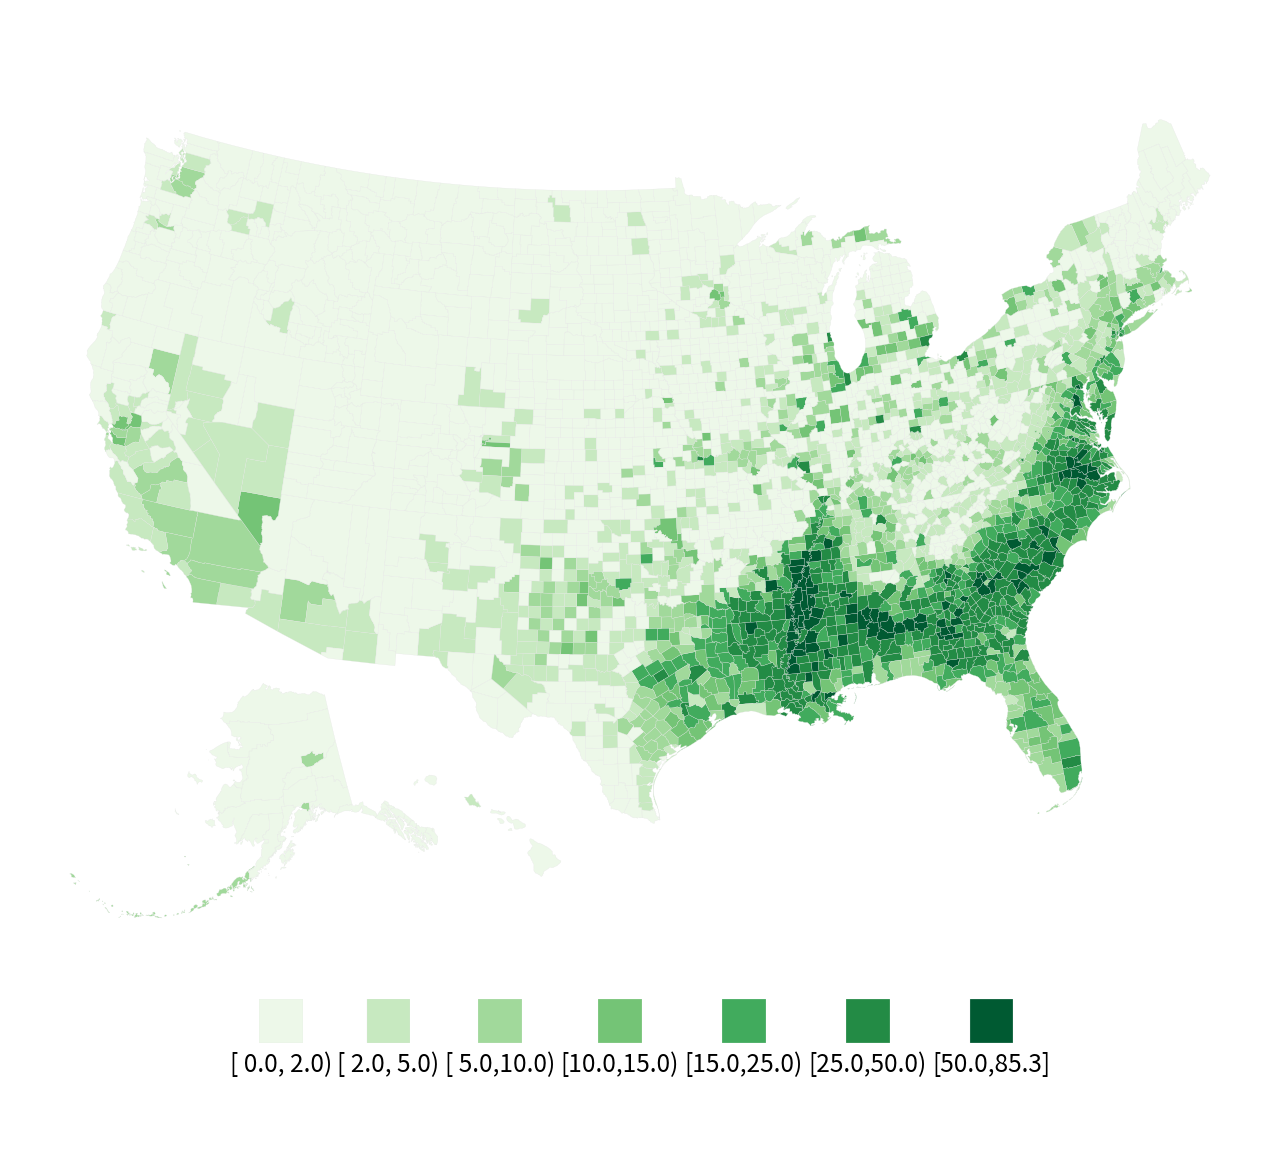

In [22]:
p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='pct_black', group='group')
)
p1 = p + geom_polygon(color=dcolors['gray90'], size=0.05) + coord_equal()
p2 = p1 + scale_fill_brewer(palette="Greens")
p2 + labs(fill="US Population, Percent Black") + guides(
    fill=guide_legend(nrow=1)
) + theme_map_pseudo() + theme(legend_position="bottom")

## 図 7.13

注 1: **plotnine** は現時点 (v0.8) では `direction=-1` 引数でカラーマッピングの濃淡を反転できます. よってオリジナルの例のように反転のためだけにカラーマッピングを自作する必要はありません.

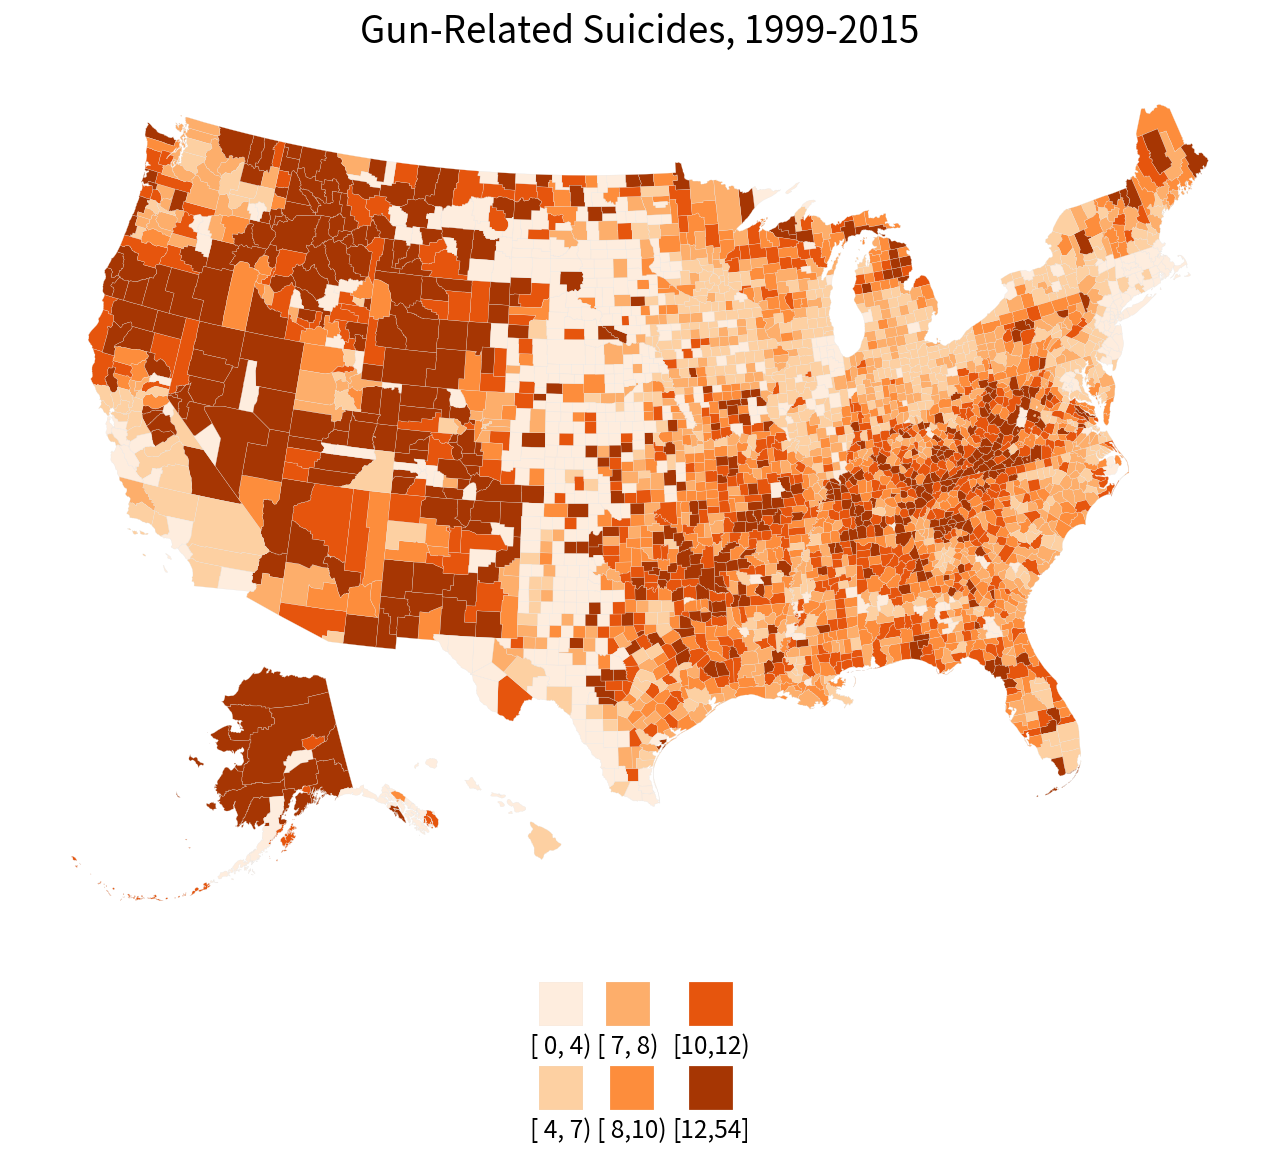

In [23]:
gun_p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='su_gun6', group='group')
)

gun_p1 = gun_p + geom_polygon(
    color=dcolors['gray90'], size=0.05) + coord_equal()

gun_p2 = gun_p1 + scale_fill_brewer(palette="Oranges")
gun_p2 + labs(
    title="Gun-Related Suicides, 1999-2015",
    fill="Rate per 100,000 pop."
) + theme_map_pseudo() + theme(legend_position="bottom")

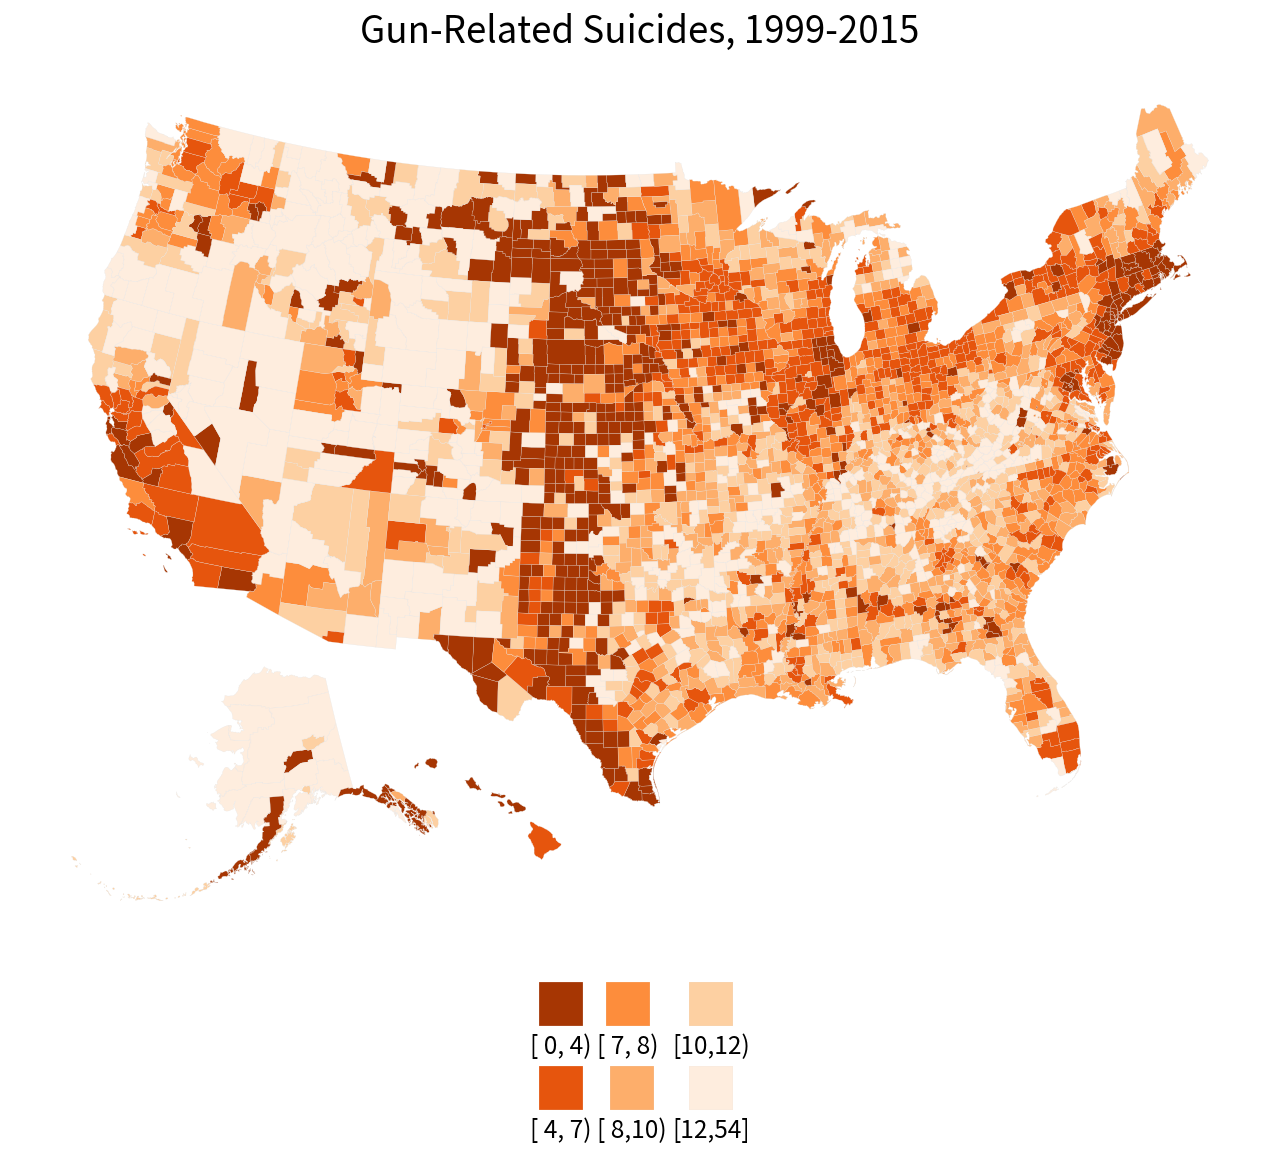

In [24]:
gun_p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='su_gun6', group='group')
)

gun_p1 = gun_p + geom_polygon(
    color=dcolors['gray90'], size=0.05) + coord_equal()

gun_p2 = gun_p1 + scale_fill_brewer(palette="Oranges", direction=-1)
gun_p2 + labs(
    title="Gun-Related Suicides, 1999-2015",
    fill="Rate per 100,000 pop."
) + theme_map_pseudo() + theme(legend_position="bottom")

もしオリジナルのコードを忠実になぞりたいなら, `brewer_pal()` を再び使用します.

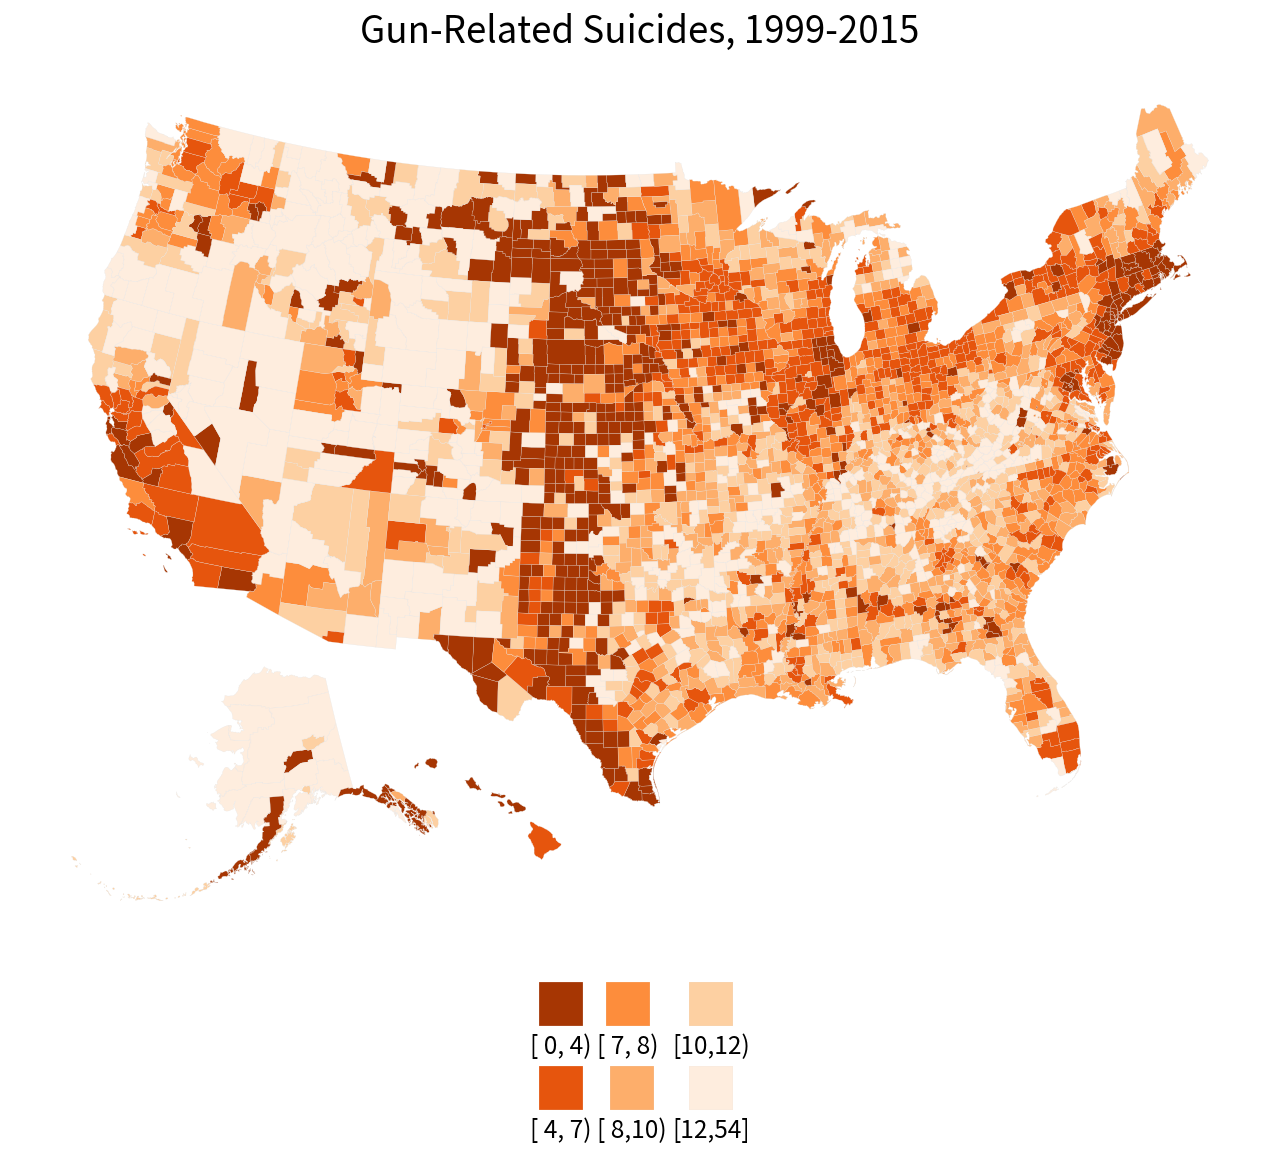

In [25]:
orange_pal = brewer_pal('sequential', "Oranges", -1)(6)

gun_p1 + scale_fill_manual(orange_pal) + labs(
    title="Gun-Related Suicides, 1999-2015",
    fill="Rate per 100,000 pop."
) + theme_map_pseudo() + theme(legend_position="bottom")

## 図 7.14

注: お約束どおり Python では **statebins** パッケージがありません. Python スクリプトを公開しているユーザも見つけられましたが, 汎用的に使えるものではありませんでした. そこでここでは最低限の機能の関数を作成しています. `from pysocviz.utils import statebins` でインポートできます. 元の関数とは違い, テーマや色に関するオプションは大幅に制限されています. **plotnine** の関数を手動で追加することで調整しなければなりません.

merged by abbreviations


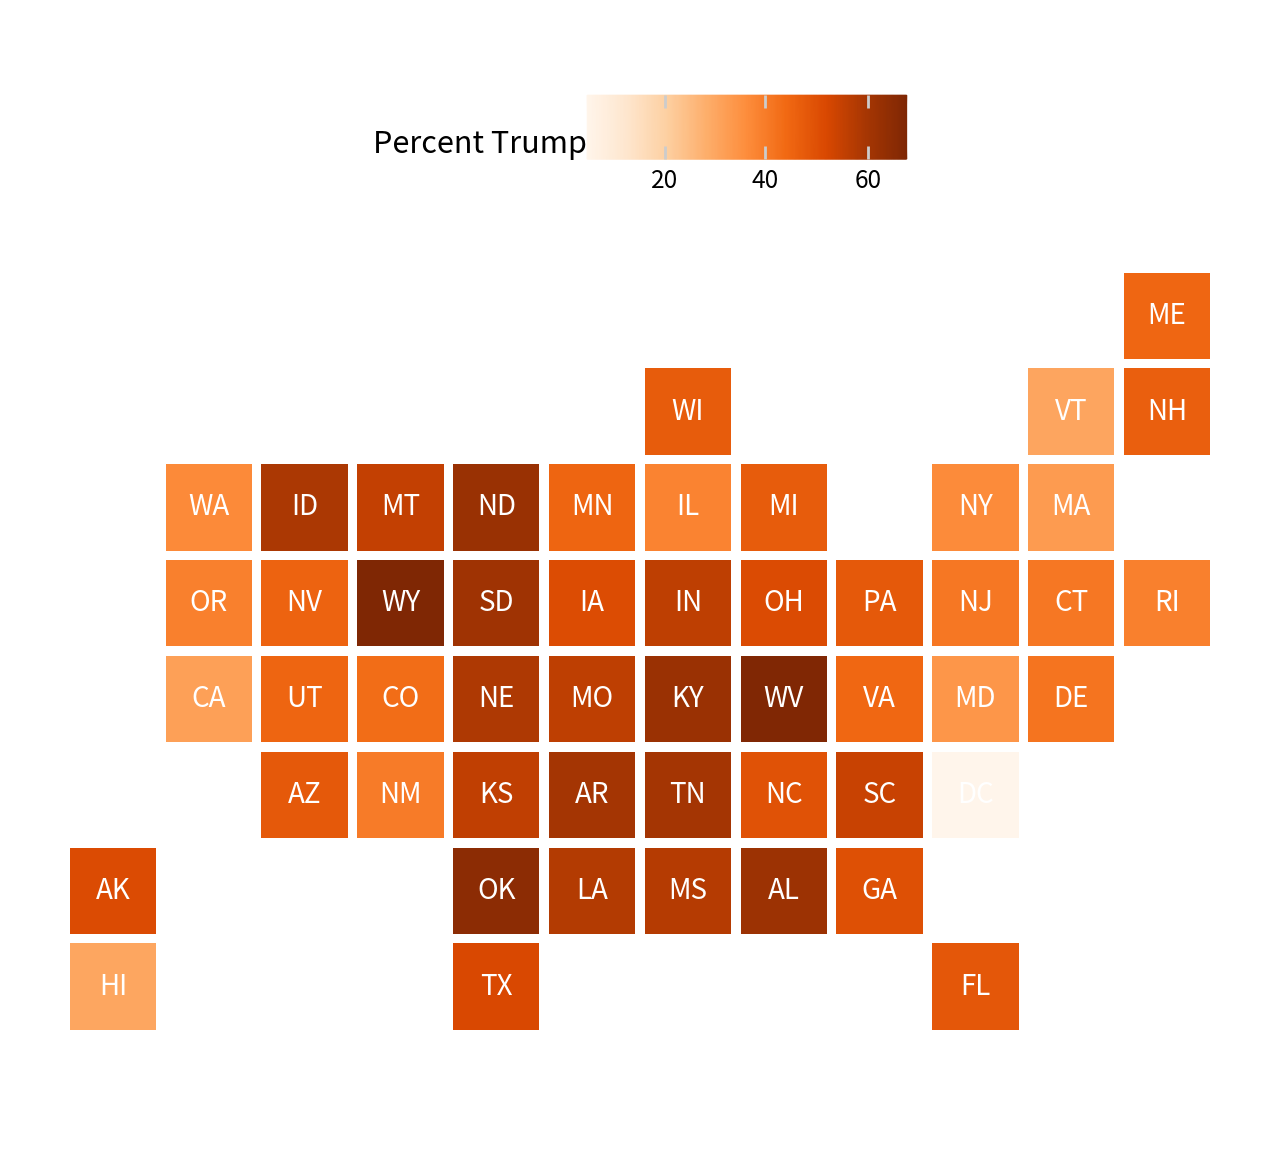

In [26]:
statebins(
    election,
    state_col='st', value_col='pct_trump', text_color='white'
) + scale_fill_cmap('Oranges', name='Percent Trump'
) + theme(legend_title=element_text(), legend_position='top')

merged by abbreviations


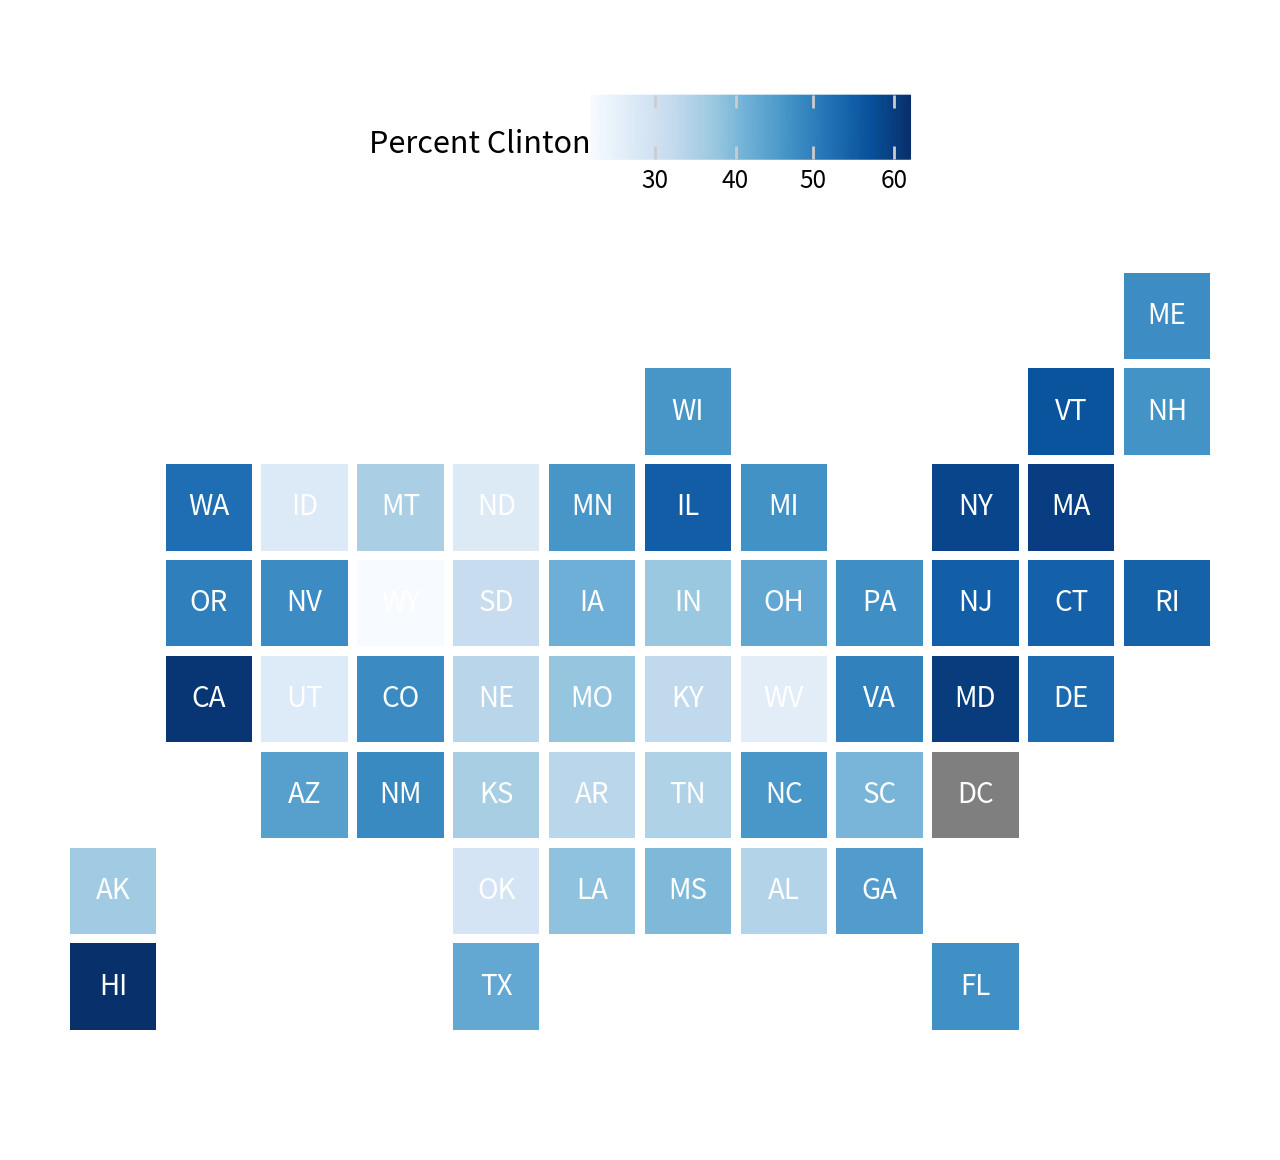

In [27]:
statebins(
    election.loc[lambda d: d['st']!='DC'],
    state_col='st', value_col='pct_clinton', text_color='white'
) + scale_fill_cmap('Blues', name='Percent Clinton'
) + theme(legend_title=element_text(), legend_position='top')

## 図 7.15

注: 数量変数を離散化するには `pd.cut()` を使うと便利です.

merged by state names


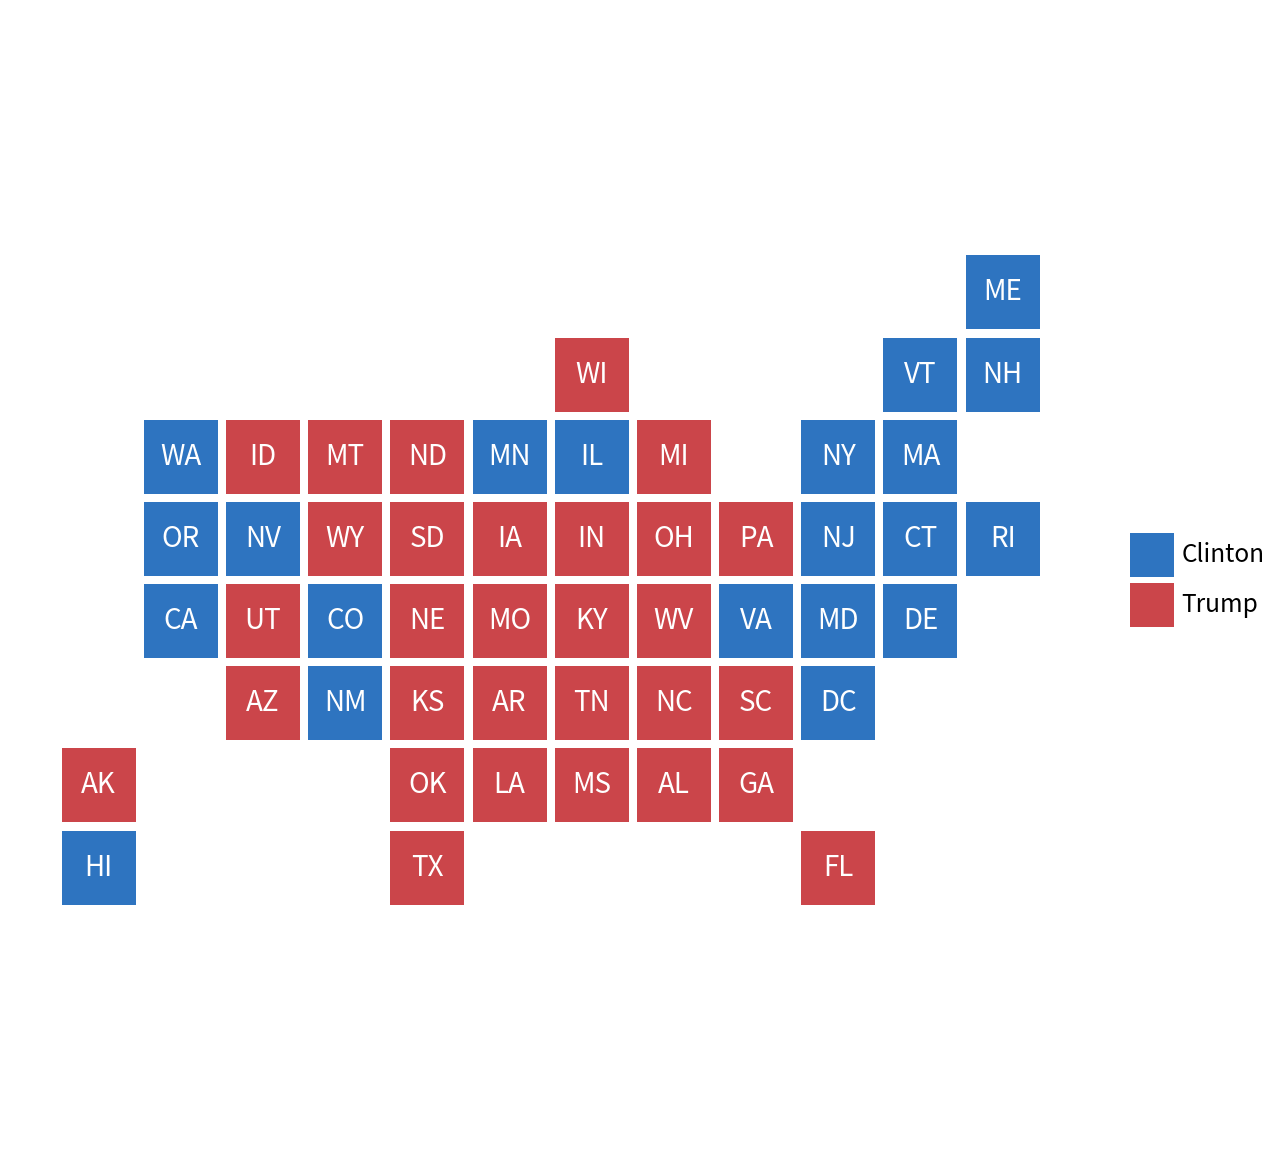

In [28]:
statebins(
    election, state_col='state', value_col='party', text_color='white'
) + scale_fill_manual(
    party_colors,  # defined at 図 7.2
    labels=lambda labs: [{'Democratic': 'Clinton', 'Republican': 'Trump'}[x] for x in labs]
) + theme(
    legend_position='right'
)

merged by state names


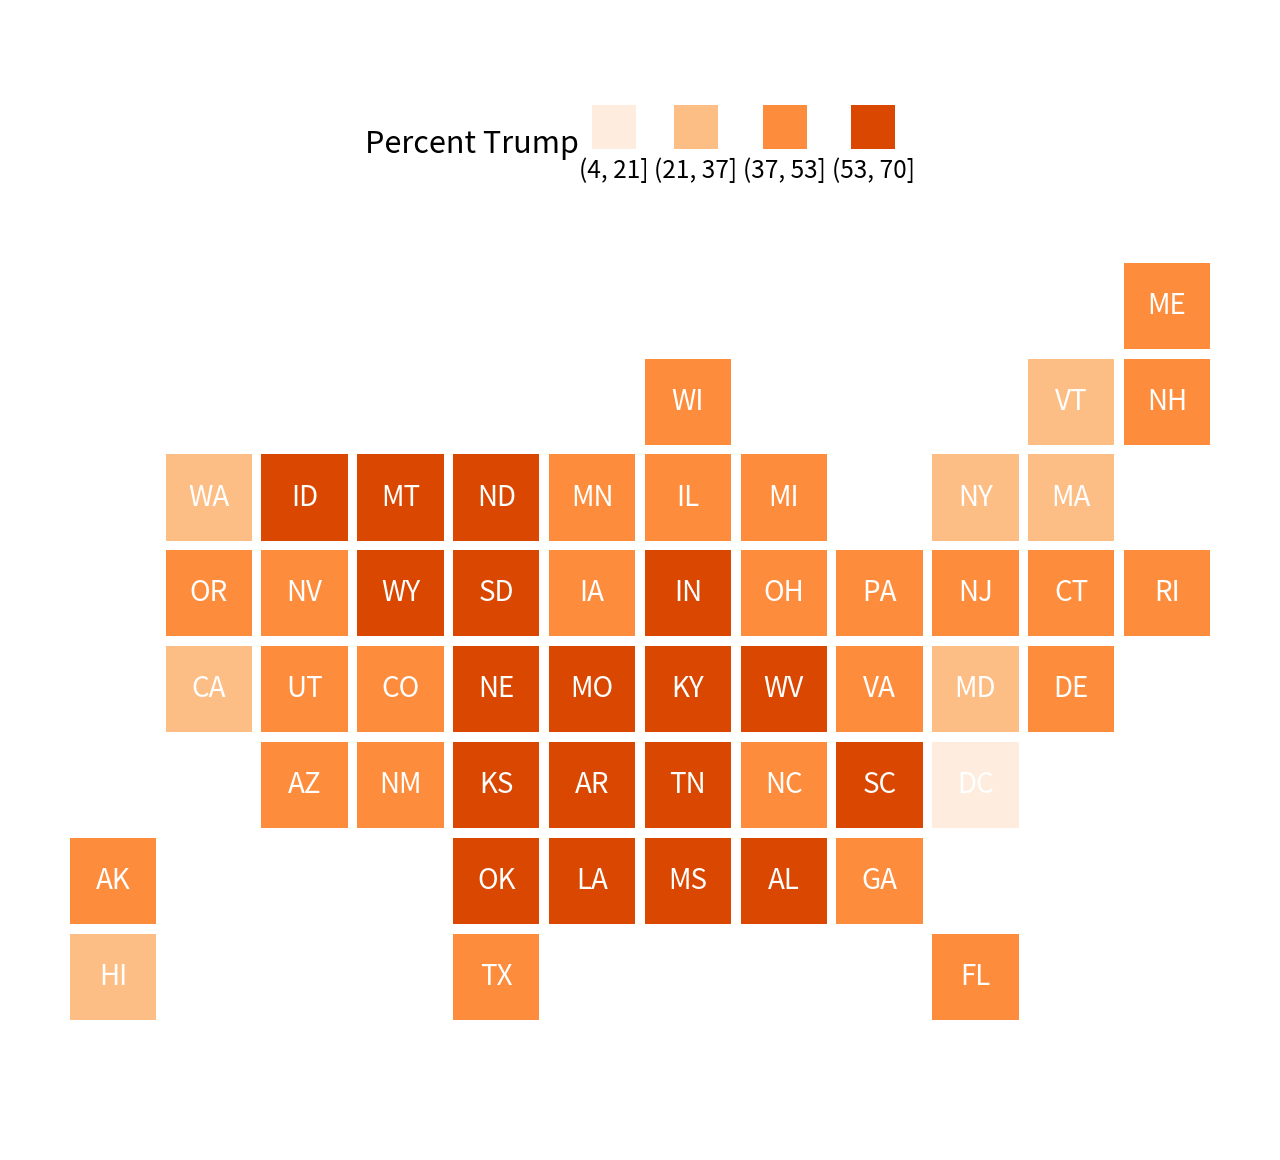

In [29]:
statebins(
    election.assign(pct_trump=lambda d: pd.cut(d['pct_trump'], [4, 21, 37, 53, 70])),
    state_col='state', value_col='pct_trump', text_color='white'
) + scale_fill_brewer(
    palette="Oranges", name='Percent Trump'
) + theme(legend_title=element_text(), legend_position='top')

## 図 7.16

注: 原著のコードの `scale_fill_viridis_c(option = "plasma")` は "plasma" というカラーマッピングを使用していることを意味します.

In [30]:
opiates = opiates.assign(region=lambda d: d['state'].str.lower())
opiates_map = us_states.merge(opiates, on='region', how='left')

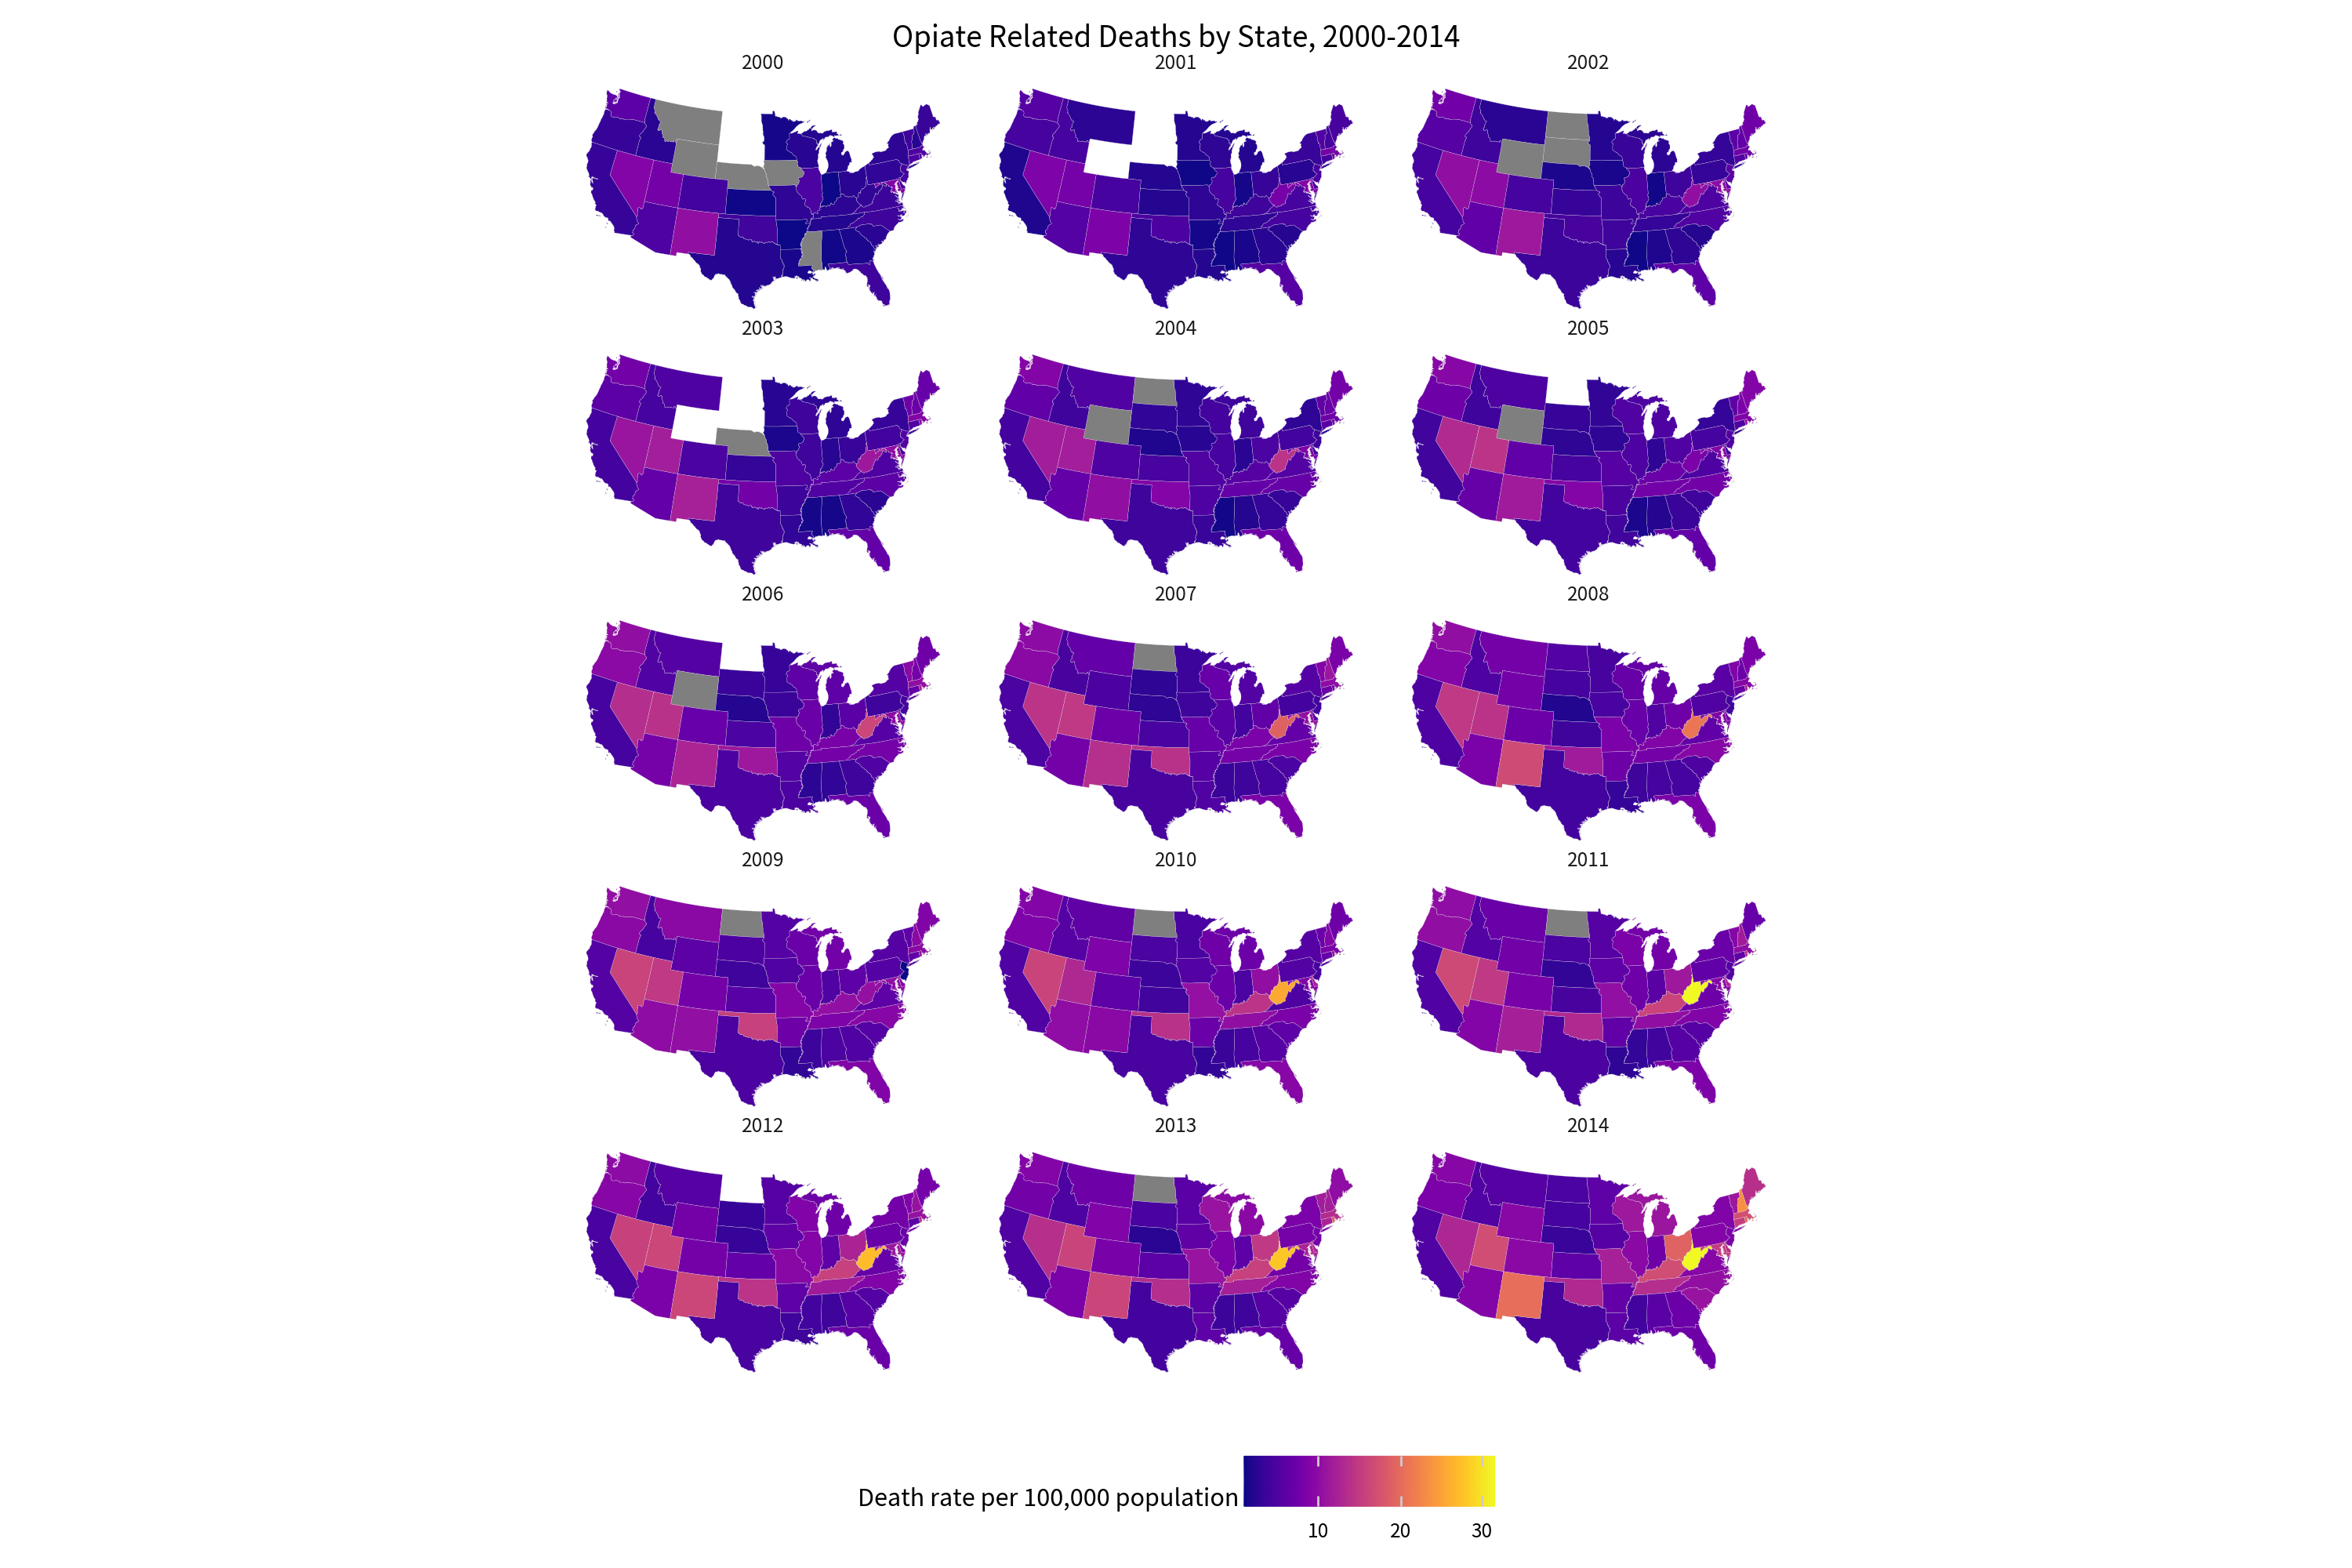

In [31]:
p0 = ggplot(
    opiates_map.loc[lambda d: d['year'] > 1999],
    aes(fill='adjusted')
)

p1 = p0 + geom_map(color=dcolors['gray90'], size=.05)
p2 = p1 + scale_fill_cmap('plasma')

p2 + theme_map_pseudo(
) + facet_wrap('~ year', ncol=3) + theme(
    legend_position="bottom",
    strip_background=element_blank(),
    legend_title=element_text()
) + labs(
    fill="Death rate per 100,000 population ",
    title="Opiate Related Deaths by State, 2000-2014"
) + coord_fixed() + theme(
    figure_size=(15, 10)
)

## 図 7.17

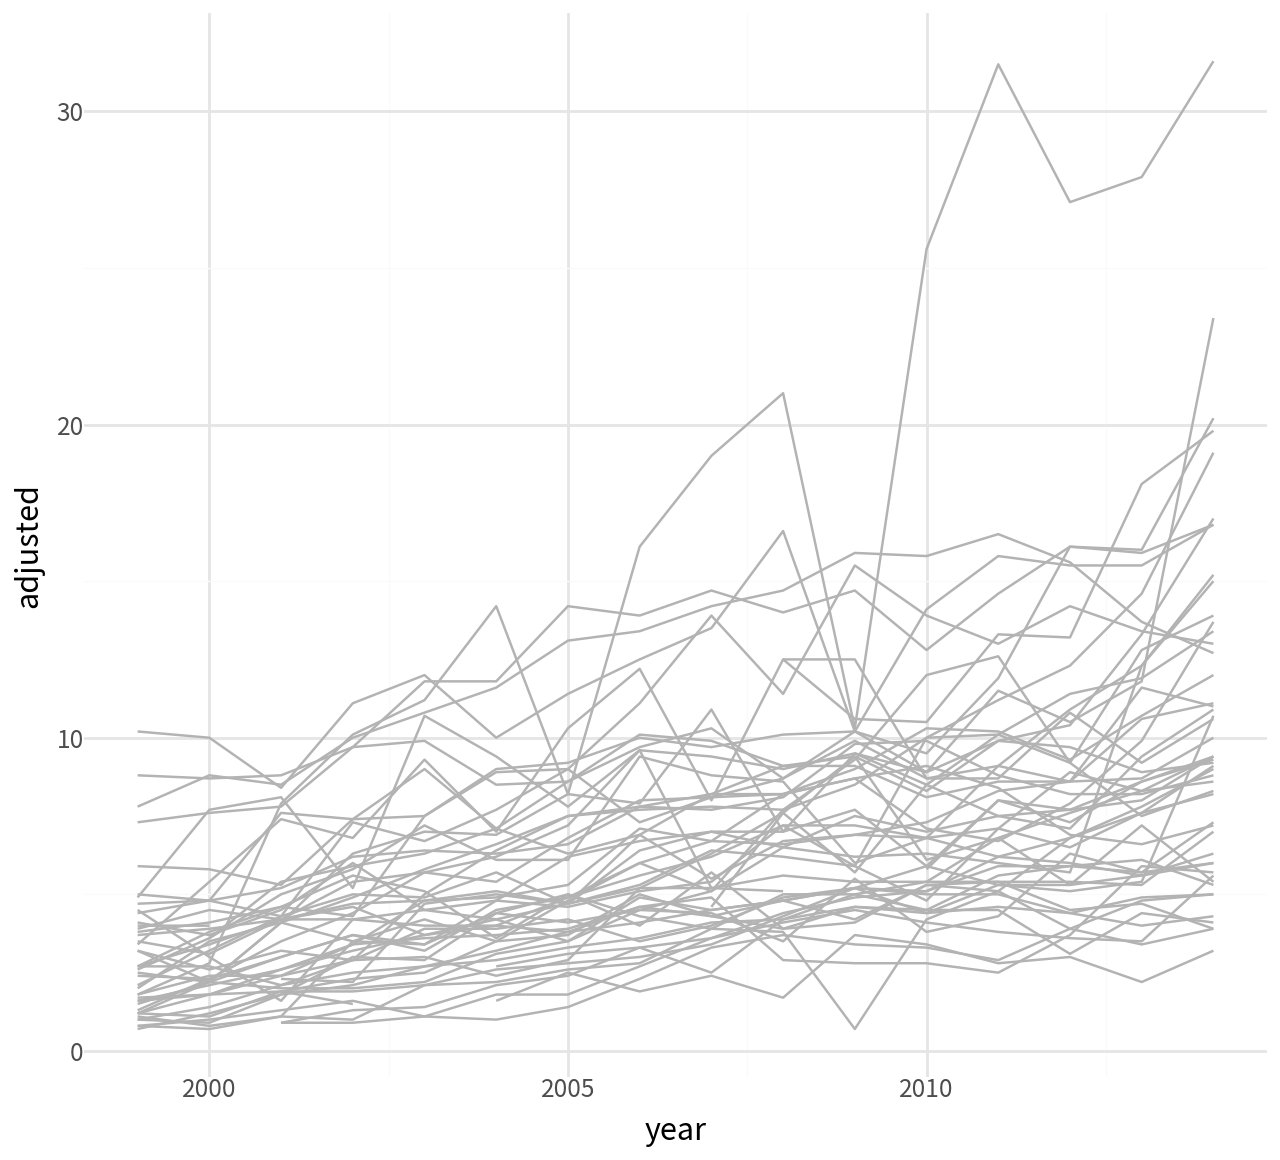

In [32]:
p = ggplot(opiates, aes(x='year', y='adjusted', group='state'))
p + geom_line(color=dcolors['gray70'])

## 図 7.18

注 1: Pandas 版では `division_name` 列の欠損値は`"nan"` という文字になっています. よって `.dropna()` や `.isna()` では除去できません.

注 2: **plotnine** は現時点では (v0.8) `geom_text` 関数の `segment.color` 引数はサポートしていませんが, `segment.color=NULL` はテキストボックスの塗りつぶしをしない (透過させる) という意味なのでここでは無視しています.

注 3: **plotnine** は現時点では (v0.8) `facet_wrap()` 内で `reorder()` を使うことはできません. ファセットの並びは `Categorical` 型 ([ここ](https://github.com/has2k1/plotnine/issues/60
)参照) に依存しています. そして, データは `geom_text` で上書きされており, ここで使われている `opiates` には変換前の `division_name` が含まれているため正しく並び替えられません. 最終的に, `opiates_ordered` というデータフレームを新しく作って `division_name` を予め並び替えることにしました.

注 4: この例では `adjust_text` がなぜか適切に機能しません. そこでテキストの重なりは放置することにしました.

In [33]:
# determine the order of `division_name`
means_adjusted = opiates.loc[lambda d: d['division_name']!='nan'].groupby(
    'division_name'
)[['adjusted']].mean().sort_values('adjusted', ascending=False)
cat_dname = pd.CategoricalDtype(categories=means_adjusted.index, ordered=True)

opiates_ordered = opiates.loc[
    lambda d: d['division_name']!='nan'
].assign(
    division_name=lambda d: d['division_name'].astype(cat_dname)
)

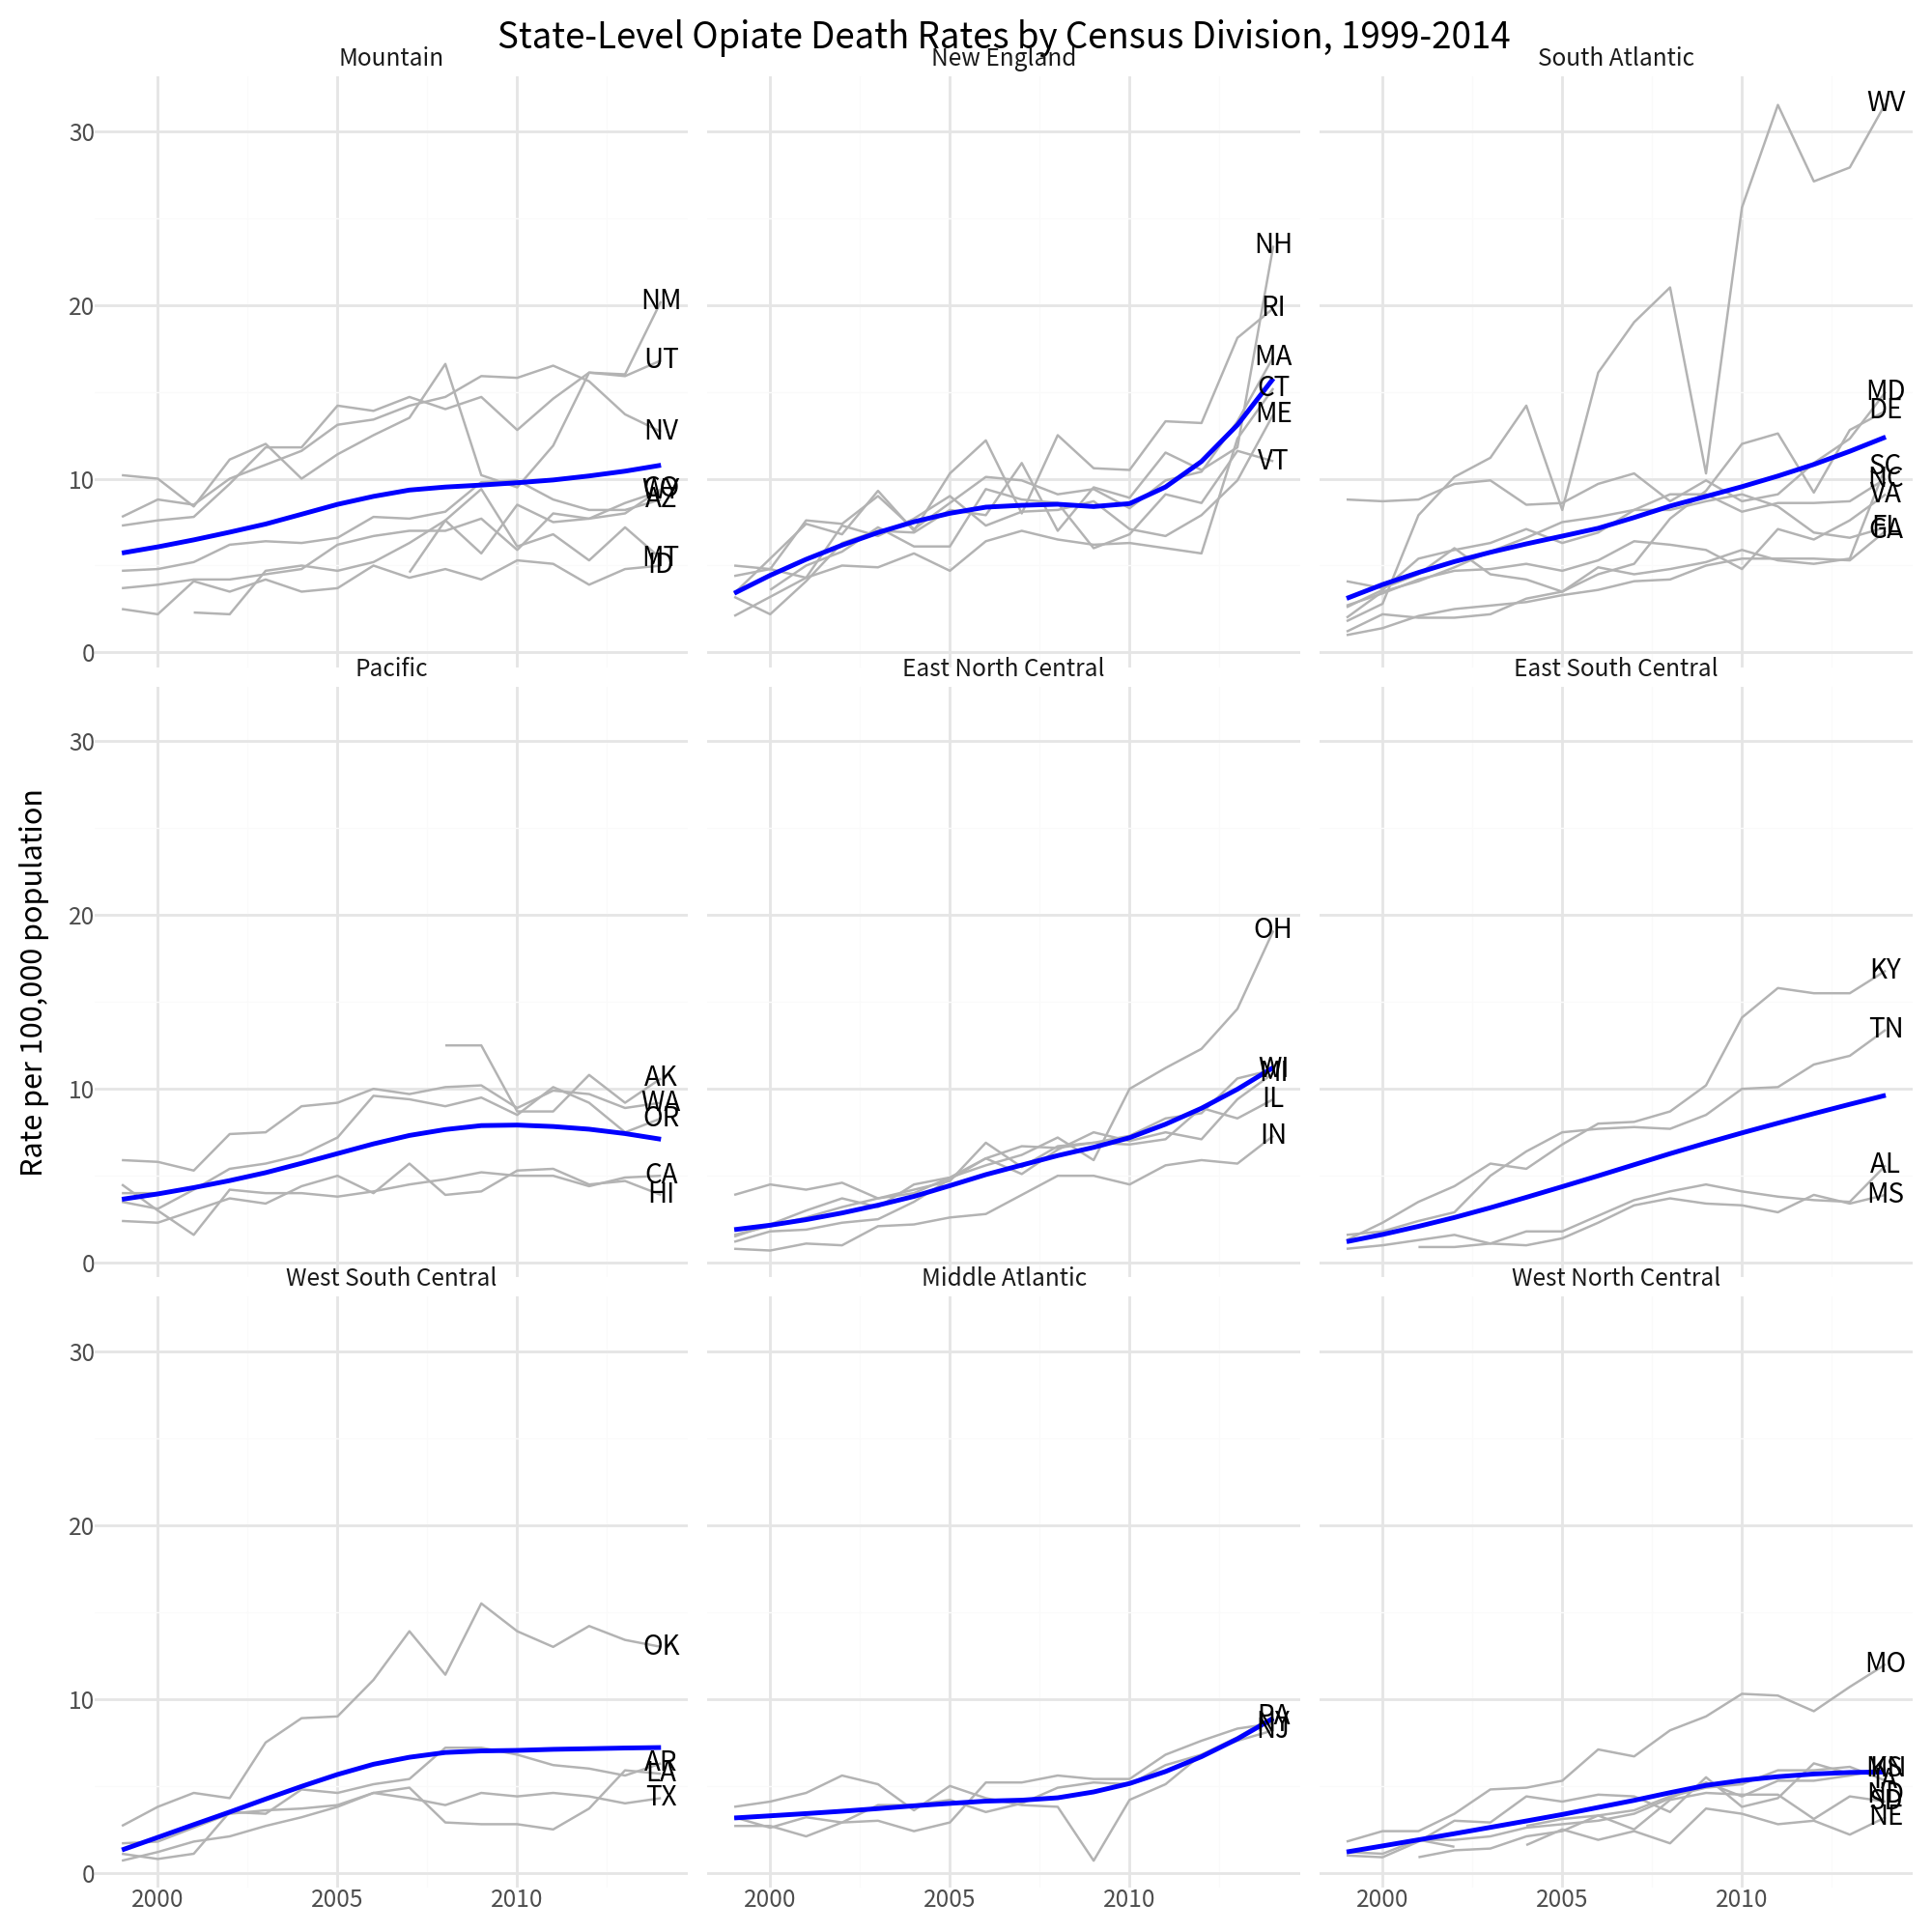

In [34]:
p0 = ggplot(opiates_ordered, aes(x='year', y='adjusted'))

p1 = p0 + geom_line(aes(group='state'), color=dcolors['gray70']) 
p2 = p1 + geom_smooth(aes(group='division_name'), se=False, color='blue')
p3 = p2 + geom_text(
    opiates_ordered.loc[
        lambda d: (d['year']==d['year'].max()) & (d['abbr'] != 'DC')
    ],
    aes(x='year', y='adjusted', label='abbr'), size=10
) + coord_cartesian([opiates['year'].min(),  opiates['year'].max()])
p3 + labs(
    x="",
    y="Rate per 100,000 population",
    title="State-Level Opiate Death Rates by Census Division, 1999-2014"
) + facet_wrap('~division_name', nrow=3) + theme(
    figure_size=(10, 10)
)